## 词表信息展示
TODO：
根据vocab.json文件，纵向排版，绘制词频分析，词频从上到下递增

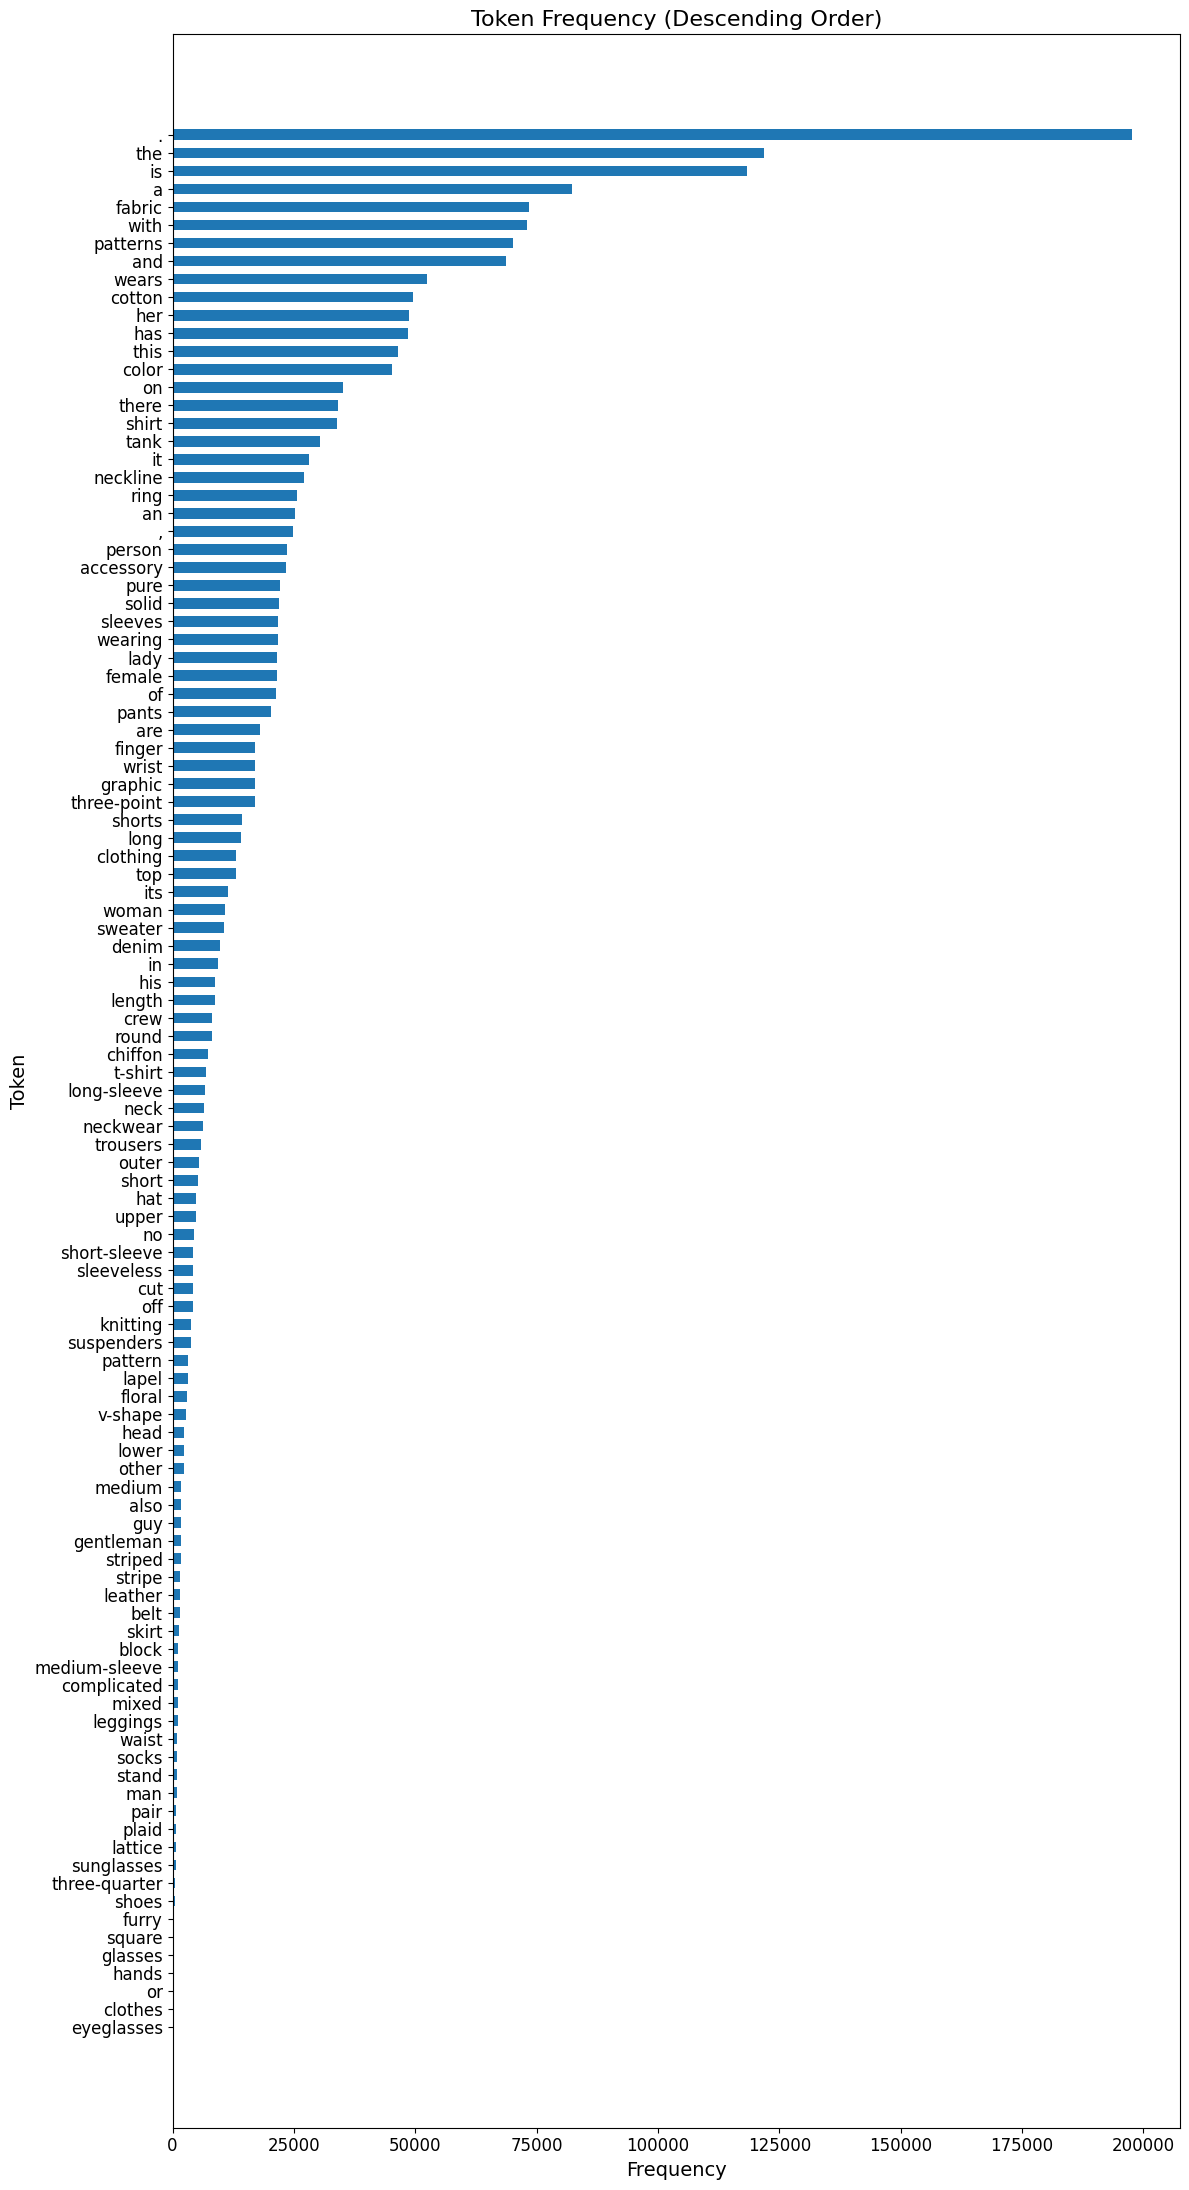

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

# 词表路径
path = "/home/chenzhican/zhangzilu/NNDL-course-captioning/data/vocab.json"

# 加载词表
with open(path, "r") as f:
    vocab = json.load(f)

freq = vocab["freq"]
items = sorted(freq.items(), key=lambda x: x[1], reverse=True)

tokens = [w for w, c in items]
counts = [c for w, c in items]

# =============================
# 横向柱状图（增强可读性版本）
# =============================
plt.figure(figsize=(12, 22))  # 图更高，条之间间隔更大
plt.barh(tokens, counts, height=0.6)  # height < 1 可以加大间距

plt.gca().invert_yaxis()       # 高频词在最上方

plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Token", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title("Token Frequency (Descending Order)", fontsize=16)
plt.tight_layout()
plt.show()


## 词嵌入信息分析
TODO：
1.做嵌入范数分析，计算每个token的范数，按照 “## 词表信息展示”中的顺序绘制同样的纵向图
2.所有token的词嵌入是一个向量组，对这个向量组做PCA，获取其主成分，依方差解释率从大到小排列，绘制图像。


/home/chenzhican/miniconda3/envs/nndl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Loading local ViT weights from: /home/chenzhican/zhangzilu/hwnndl/model/weights/jx_vit_base_p16_224-80ecf9dd.pth
[INFO] Missing keys: []
[INFO] Unexpected keys: ['head.bias', 'head.weight']
[INFO] Missing keys: []
[INFO] Unexpected keys: ['head.bias', 'head.weight']
Embedding shape: (109, 512)
Embedding shape: (109, 512)


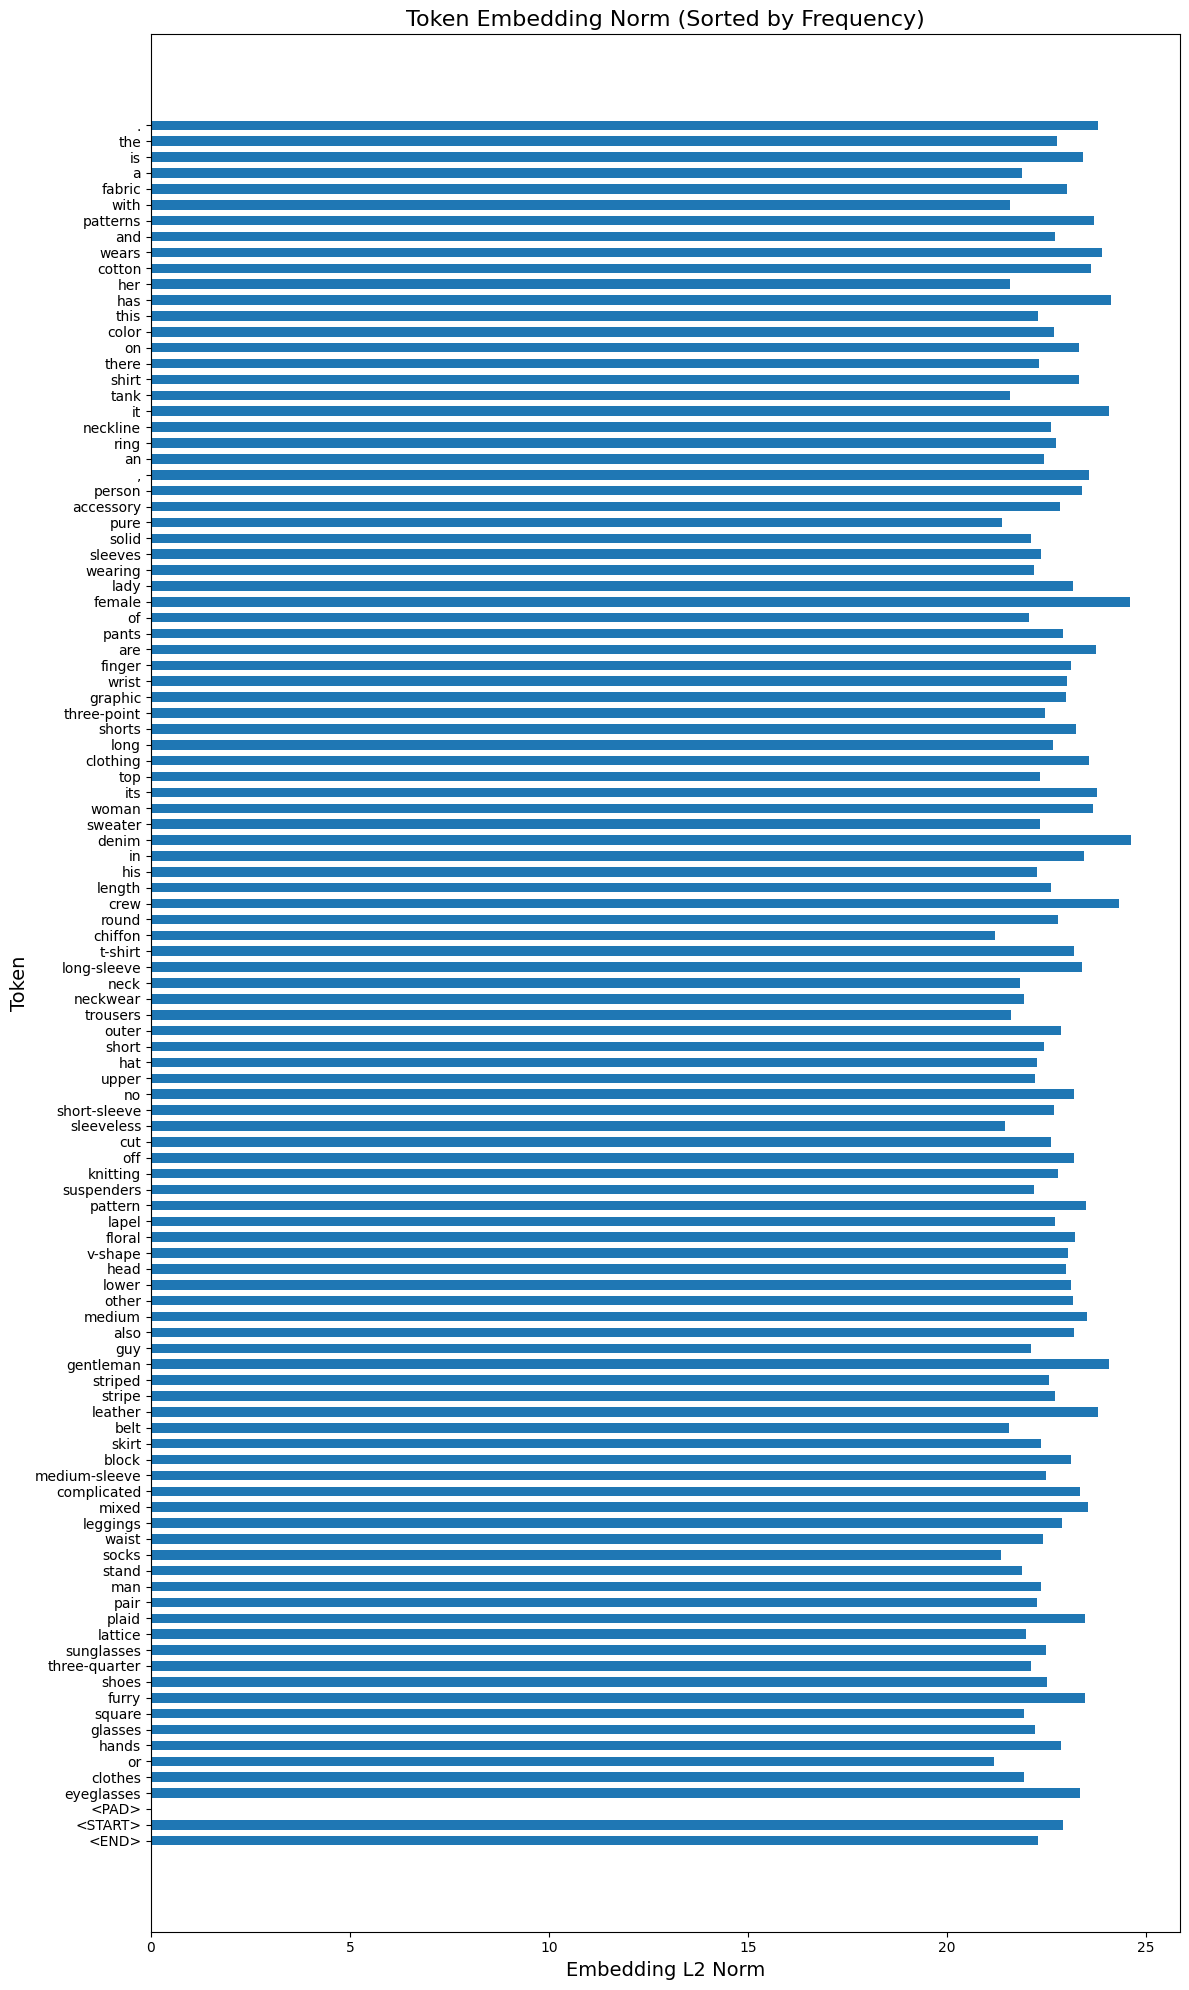

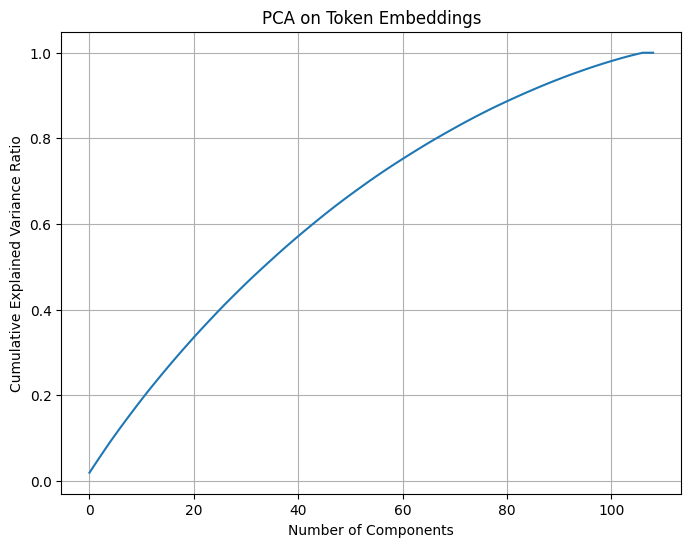

In [3]:
import sys
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

sys.path.append("/home/chenzhican/zhangzilu/NNDL-course-captioning")

# ===============================================================
# 1. load vocab
# ===============================================================

vocab_path = "/home/chenzhican/zhangzilu/NNDL-course-captioning/data/vocab.json"
with open(vocab_path, "r") as f:
    vocab = json.load(f)

token2id = vocab["token2id"]
freq = vocab["freq"]
vocab_size = len(token2id)

# ===============================================================
# 2. load model
# ===============================================================

model_path = "/home/chenzhican/zhangzilu/hwnndl/outputs/ckpts/epoch10.pth"

from models.vit_encoder_decoder import ImageCaptionModel

device = "cpu"

# ★★★ 修复：max_len 必须与训练时一致（128）
model = ImageCaptionModel(
    vocab_size=vocab_size,
    max_len=128
).to(device)

state = torch.load(model_path, map_location=device)
model.load_state_dict(state, strict=False)

emb = model.decoder.token_emb.weight.detach().cpu().numpy()
print("Embedding shape:", emb.shape)

# ===============================================================
# 3. 计算 embedding norm
# ===============================================================

norms = np.linalg.norm(emb, axis=1)

items = sorted(token2id.items(), key=lambda x: freq.get(x[0], 0), reverse=True)
tokens_sorted = [t for t, i in items]
ids_sorted = [token2id[t] for t in tokens_sorted]
norms_sorted = [norms[i] for i in ids_sorted]

# ===============================================================
# 4. 绘制 embedding 范数图
# ===============================================================

plt.figure(figsize=(12, 20))
plt.barh(tokens_sorted, norms_sorted, height=0.6)
plt.gca().invert_yaxis()
plt.xlabel("Embedding L2 Norm", fontsize=14)
plt.ylabel("Token", fontsize=14)
plt.title("Token Embedding Norm (Sorted by Frequency)", fontsize=16)
plt.tight_layout()
plt.show()

# ===============================================================
# 5. PCA
# ===============================================================

pca = PCA(n_components=min(emb.shape[0], emb.shape[1]))
pca.fit(emb)

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("PCA on Token Embeddings")
plt.grid(True)
plt.show()


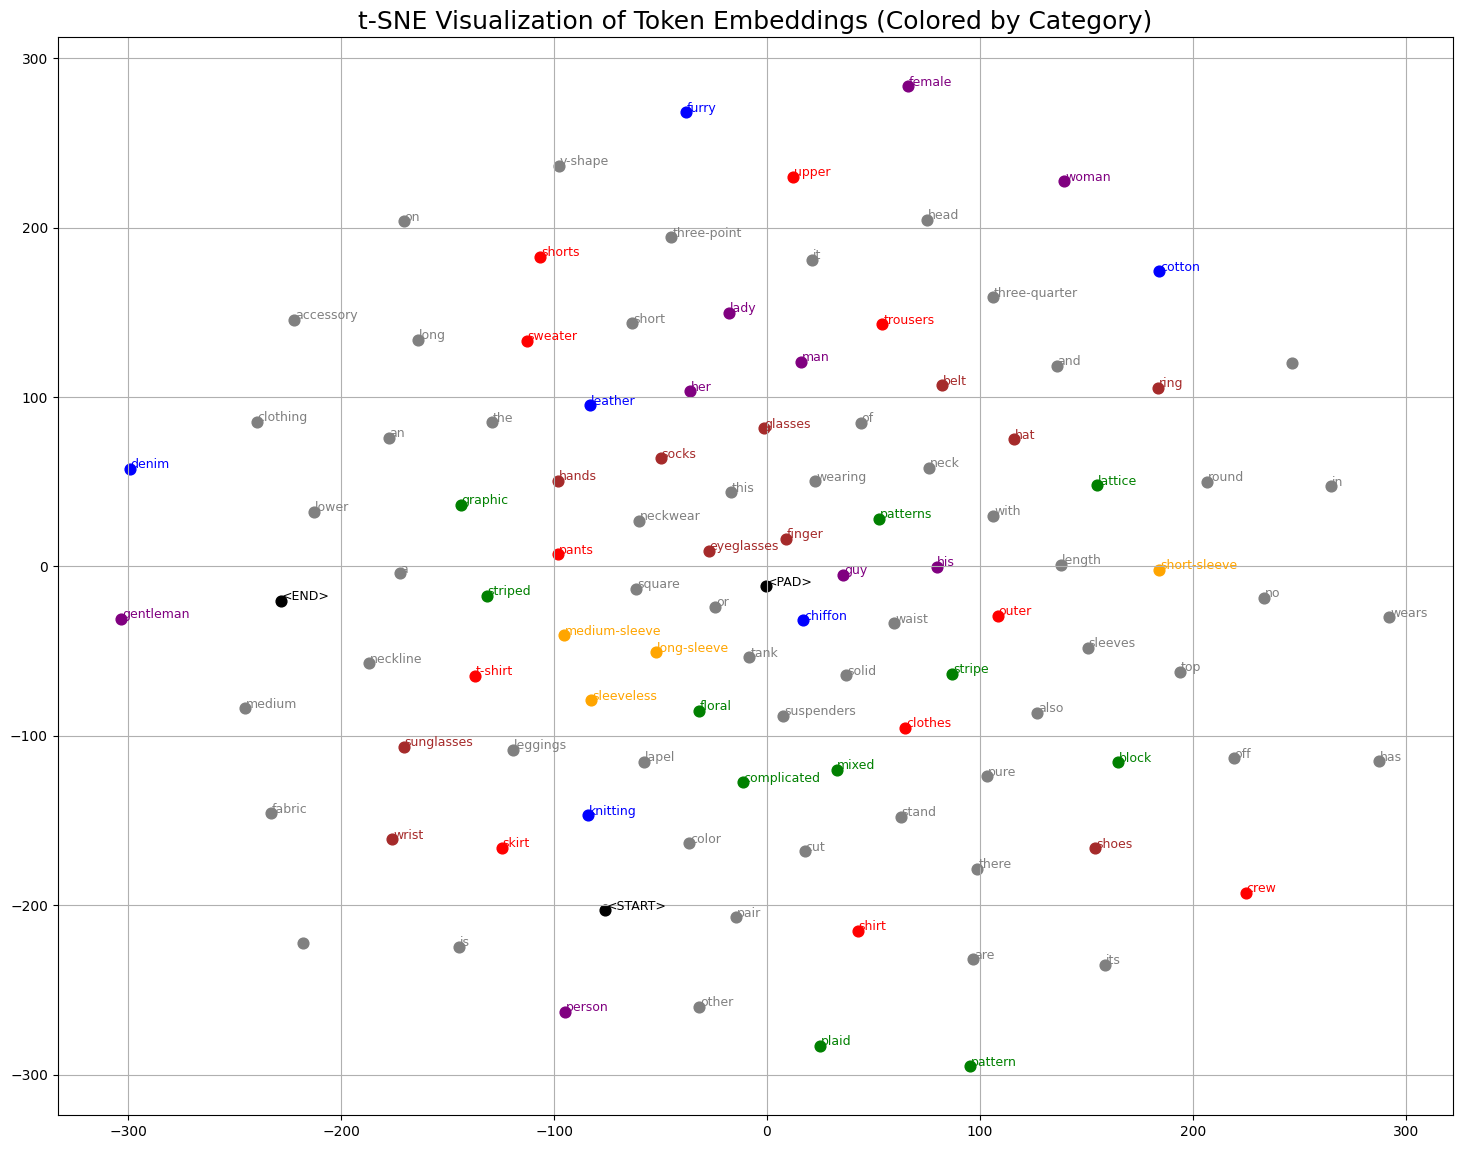

=== Token Category Color Legend ===
clothing   -> red
fabric     -> blue
pattern    -> green
sleeve     -> orange
person     -> purple
accessory  -> brown
special    -> black
other      -> gray


In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# ===============================================================
# 1. 构造 token 分类规则（根据你的词表结构自动分类）
# ===============================================================

category_map = {}

clothing_keywords = [
    "shirt", "pants", "skirt", "shorts", "t-shirt", "trousers",
    "sweater", "outer", "upper", "crew", "clothes"
]

fabric_keywords = [
    "cotton", "denim", "chiffon", "knitting", "leather", "furry"
]

pattern_keywords = [
    "plaid", "stripe", "striped", "pattern", "patterns", "graphic",
    "floral", "lattice", "block", "mixed", "complicated"
]

sleeve_keywords = [
    "long-sleeve", "short-sleeve", "sleeveless", "medium-sleeve"
]

person_keywords = [
    "man", "woman", "lady", "female", "gentleman", "person", "guy", "his", "her"
]

accessory_keywords = [
    "belt", "hat", "sunglasses", "glasses", "eyeglasses", "ring", 
    "finger", "wrist", "hands", "socks", "shoes"
]

# 分配类别
for token in token2id.keys():
    if token in clothing_keywords:
        category_map[token] = "clothing"
    elif token in fabric_keywords:
        category_map[token] = "fabric"
    elif token in pattern_keywords:
        category_map[token] = "pattern"
    elif token in sleeve_keywords:
        category_map[token] = "sleeve"
    elif token in person_keywords:
        category_map[token] = "person"
    elif token in accessory_keywords:
        category_map[token] = "accessory"
    elif token.startswith("<"):   # special tokens
        category_map[token] = "special"
    else:
        category_map[token] = "other"

# ===============================================================
# 2. 给类别分配颜色
# ===============================================================

color_dict = {
    "clothing": "red",
    "fabric": "blue",
    "pattern": "green",
    "sleeve": "orange",
    "person": "purple",
    "accessory": "brown",
    "special": "black",
    "other": "gray",
}

# ===============================================================
# 3. t-SNE 降维（复用上个单元格的 emb）
# ===============================================================

emb = model.decoder.token_emb.weight.detach().cpu().numpy()
tokens = list(token2id.keys())

perplexity = min(30, len(tokens)//3)
perplexity = max(5, perplexity)

tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    init="random",
    learning_rate=200
)
emb_2d = tsne.fit_transform(emb)

# ===============================================================
# 4. 绘制 t-SNE 图（按类别上色）
# ===============================================================

plt.figure(figsize=(18, 14))

for i, token in enumerate(tokens):
    x, y = emb_2d[i]
    cat = category_map[token]
    color = color_dict[cat]
    plt.scatter(x, y, color=color, s=60)
    plt.text(x + 0.4, y + 0.4, token, fontsize=9, color=color)

plt.title("t-SNE Visualization of Token Embeddings (Colored by Category)", fontsize=18)
plt.grid(True)
plt.show()

# ===============================================================
# 5. 打印颜色说明（Legend）
# ===============================================================

print("=== Token Category Color Legend ===")
for cat, color in color_dict.items():
    print(f"{cat:10s} -> {color}")


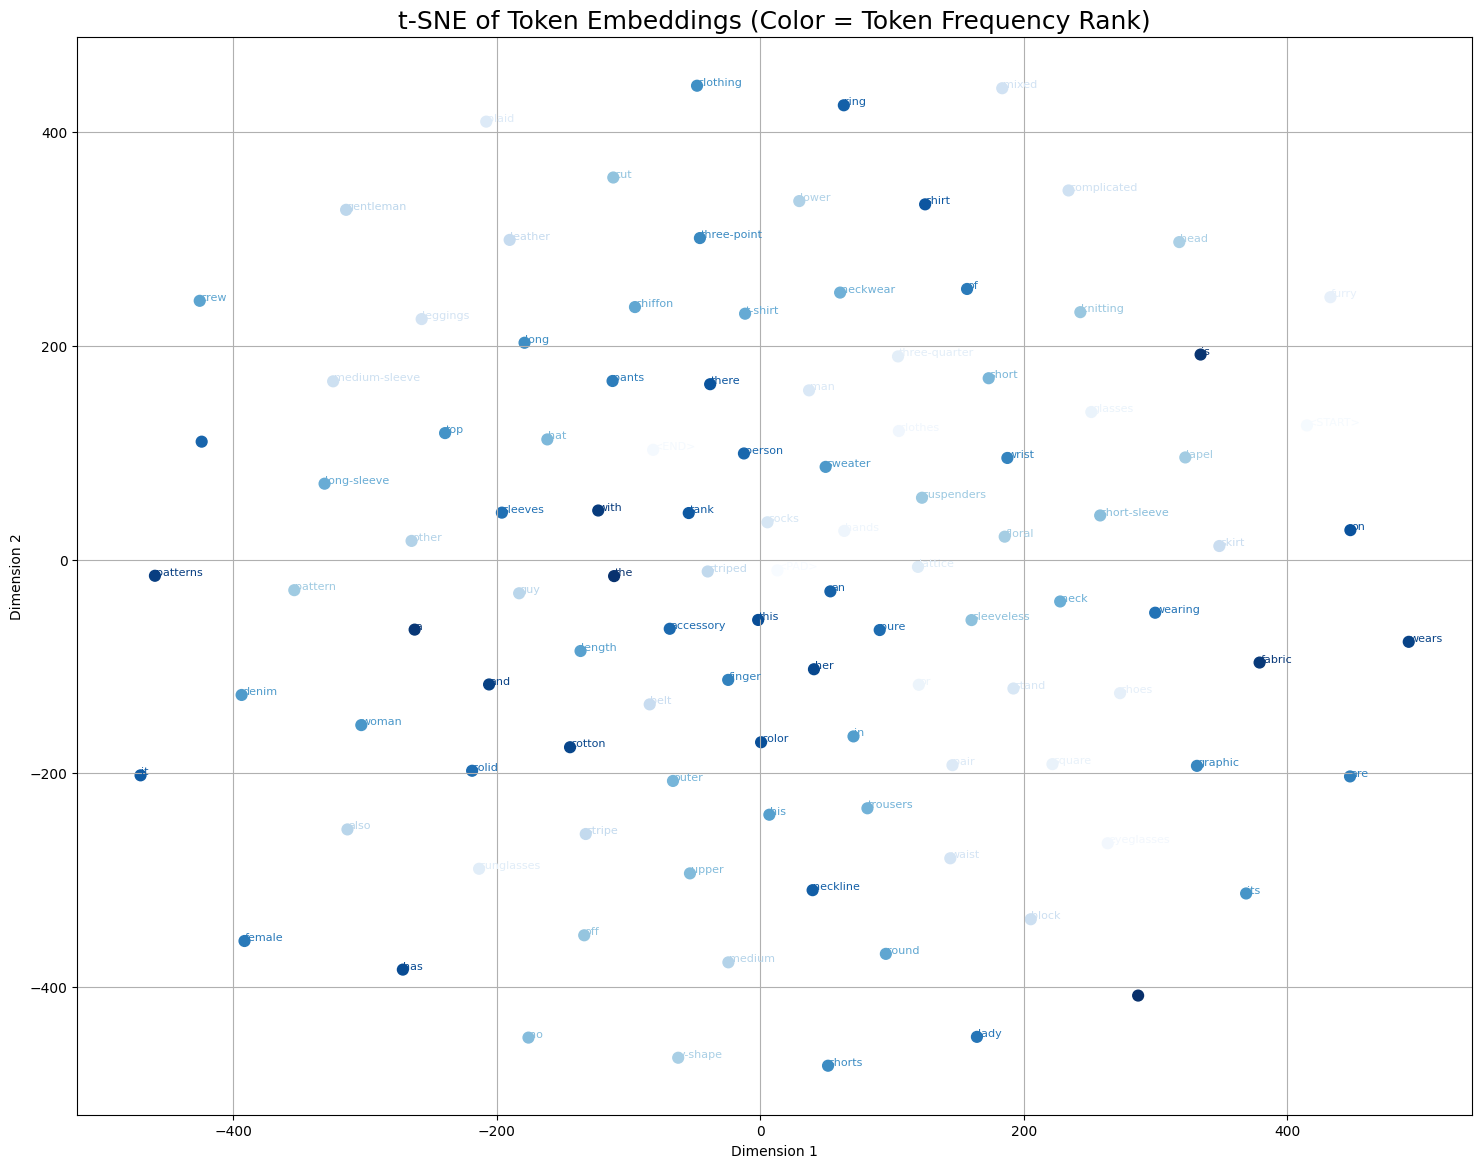

=== Color Depth Meaning (Blue colormap via RANK) ===
Deep Blue   -> Highest-frequency tokens
Medium Blue -> Medium-frequency tokens
Light Blue  -> Low-frequency tokens
White-ish   -> Rare tokens

Token frequency range: 0.0 to 197655.0
Token rank range (0 = rare, N-1 = frequent): 0 to 108


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import cm

# ===============================================================
# 1. 准备数据
# ===============================================================

emb = model.decoder.token_emb.weight.detach().cpu().numpy()
tokens = list(token2id.keys())

# 获得 token 频率
freq_arr = np.array([freq.get(t, 0) for t in tokens], dtype=float)

# 按频率排序得到 rank：0 = 最低频，N-1 = 最高频
ranks = freq_arr.argsort().argsort()
rank_norm = ranks / (len(tokens) - 1)  # 映射到 [0,1]

# ===============================================================
# 2. t-SNE 降维
# ===============================================================

perplexity = min(30, len(tokens) // 3)
perplexity = max(5, perplexity)

tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    init="random",
    learning_rate=200
)
emb_2d = tsne.fit_transform(emb)

# ===============================================================
# 3. 可视化（深浅明显）
# ===============================================================

plt.figure(figsize=(18, 14))

# 这里依旧用 Blues，但 rank_norm 使深浅呈严格从浅→深
colors = cm.Blues(rank_norm)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], color=colors, s=60)

for i, token in enumerate(tokens):
    x, y = emb_2d[i]
    plt.text(x + 0.5, y + 0.5, token, fontsize=8, color=colors[i])

plt.title("t-SNE of Token Embeddings (Color = Token Frequency Rank)", fontsize=18)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

# ===============================================================
# 4. 打印 rank→色深 信息
# ===============================================================

print("=== Color Depth Meaning (Blue colormap via RANK) ===")
print("Deep Blue   -> Highest-frequency tokens")
print("Medium Blue -> Medium-frequency tokens")
print("Light Blue  -> Low-frequency tokens")
print("White-ish   -> Rare tokens")
print("")
print("Token frequency range:", freq_arr.min(), "to", freq_arr.max())
print("Token rank range (0 = rare, N-1 = frequent):", ranks.min(), "to", ranks.max())


Embedding shape: V=109, D=512
各维度均值范围: [-0.2637, 0.2858]
各维度标准差范围: [0.7803, 1.1701]
均值绝对值平均: 0.0778
标准差平均: 0.9958


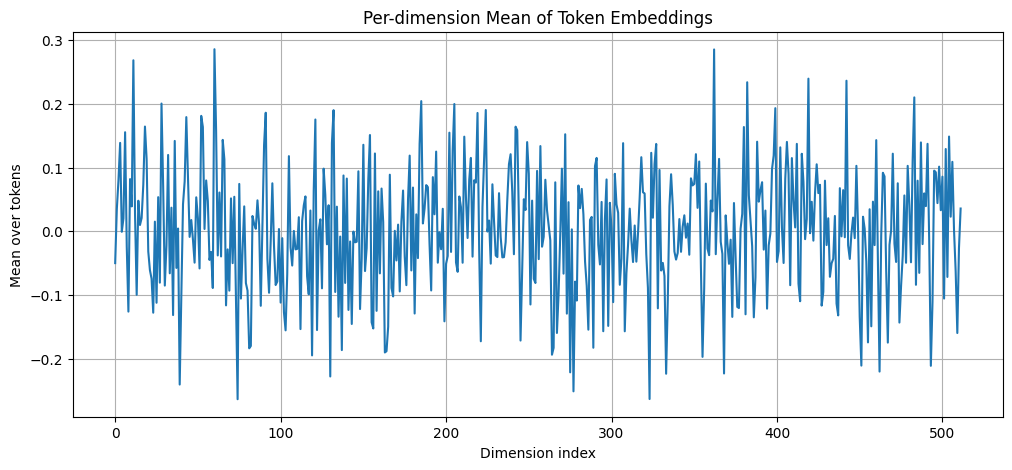

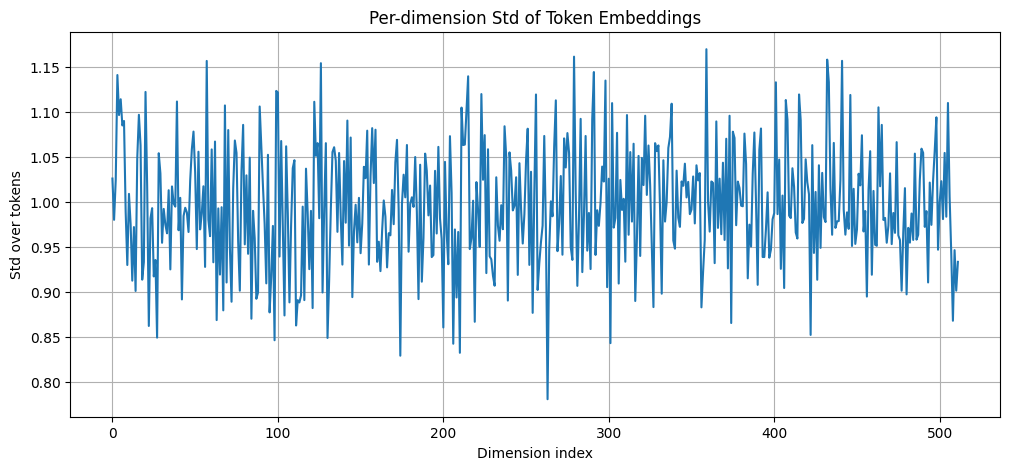

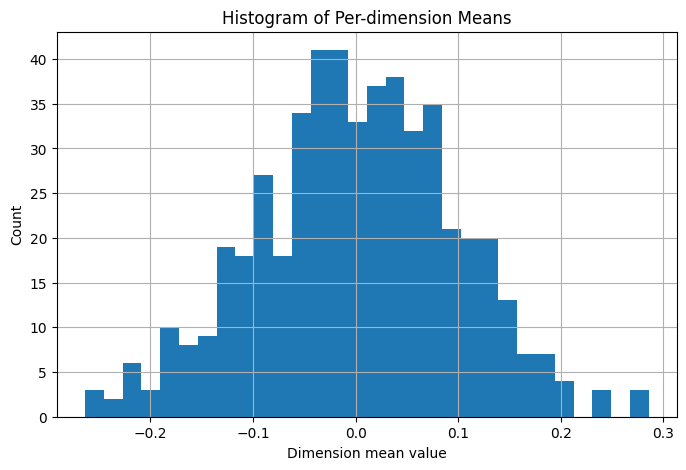

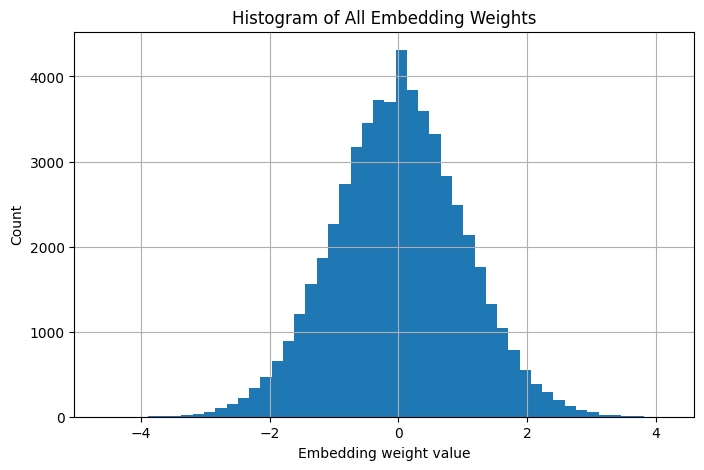

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 如果上面单元格已经有 emb，就可以直接用
# 否则取消下面一行注释重新取一次
# emb = model.decoder.token_emb.weight.detach().cpu().numpy()  # [V, D]

V, D = emb.shape
print(f"Embedding shape: V={V}, D={D}")

# 1. 每一维在所有 token 上的均值和标准差
dim_means = emb.mean(axis=0)   # [D]
dim_stds  = emb.std(axis=0)    # [D]

print(f"各维度均值范围: [{dim_means.min():.4f}, {dim_means.max():.4f}]")
print(f"各维度标准差范围: [{dim_stds.min():.4f}, {dim_stds.max():.4f}]")
print(f"均值绝对值平均: {np.mean(np.abs(dim_means)):.4f}")
print(f"标准差平均: {np.mean(dim_stds):.4f}")

# 2. 画“维度 -> 均值 / 方差”的曲线
plt.figure(figsize=(12, 5))
plt.plot(dim_means)
plt.xlabel("Dimension index")
plt.ylabel("Mean over tokens")
plt.title("Per-dimension Mean of Token Embeddings")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(dim_stds)
plt.xlabel("Dimension index")
plt.ylabel("Std over tokens")
plt.title("Per-dimension Std of Token Embeddings")
plt.grid(True)
plt.show()

# 3. 所有维度的均值直方图（看均值是否集中在 0 左右）
plt.figure(figsize=(8, 5))
plt.hist(dim_means, bins=30)
plt.xlabel("Dimension mean value")
plt.ylabel("Count")
plt.title("Histogram of Per-dimension Means")
plt.grid(True)
plt.show()

# 4. 所有 embedding 权重的总体直方图（看整体分布形状）
plt.figure(figsize=(8, 5))
plt.hist(emb.flatten(), bins=50)
plt.xlabel("Embedding weight value")
plt.ylabel("Count")
plt.title("Histogram of All Embedding Weights")
plt.grid(True)
plt.show()


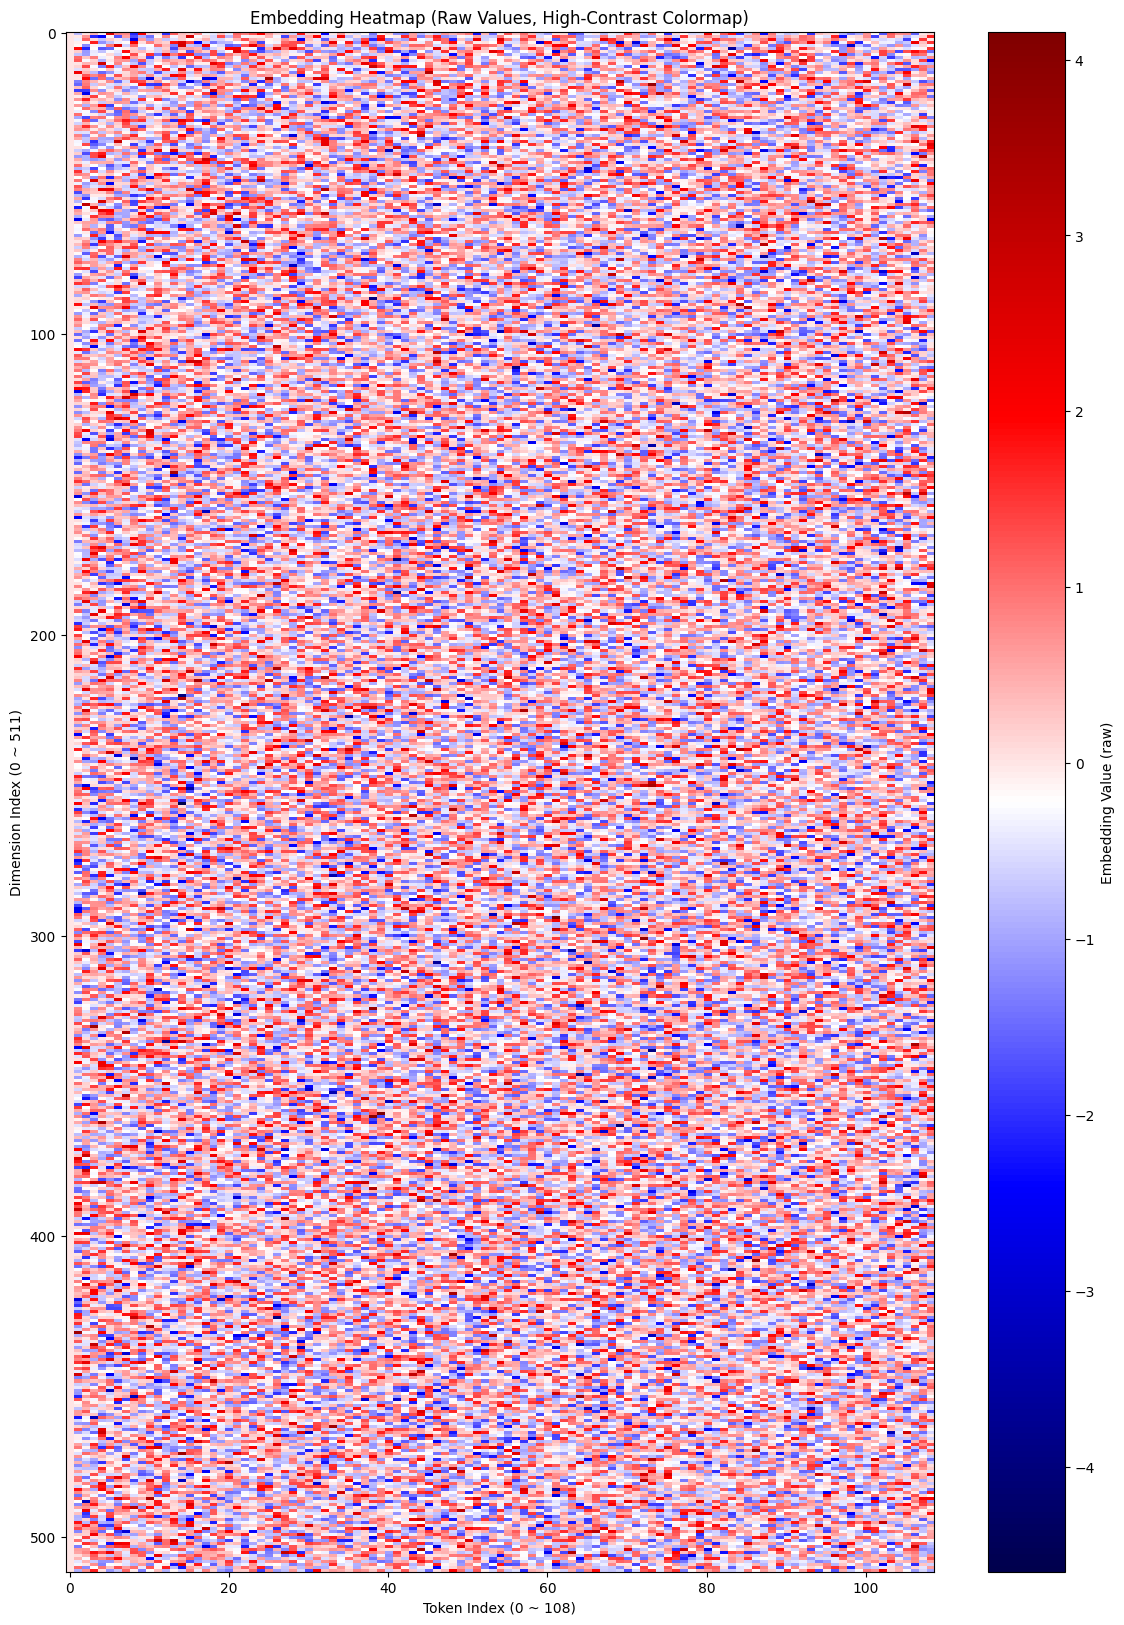

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# embedding: [V, D] = [109, 512]
emb = model.decoder.token_emb.weight.detach().cpu().numpy()

# 转置为 [D, V]
emb_T = emb.T   # shape (512, 109)

plt.figure(figsize=(14, 20))

# cmap='seismic' 是高对比度颜色映射
# 可以放大正负值差异，适合可视化原始 embedding
plt.imshow(
    emb_T,
    aspect="auto",
    cmap="seismic",        # 高对比度红蓝色盘
    interpolation="nearest"
)

plt.colorbar(label="Embedding Value (raw)")
plt.xlabel("Token Index (0 ~ 108)")
plt.ylabel("Dimension Index (0 ~ 511)")
plt.title("Embedding Heatmap (Raw Values, High-Contrast Colormap)")
plt.show()


/tmp/ipykernel_3680584/3294208963.py:9: RuntimeWarning: invalid value encountered in divide
  emb_norm = emb / np.linalg.norm(emb, axis=1, keepdims=True)


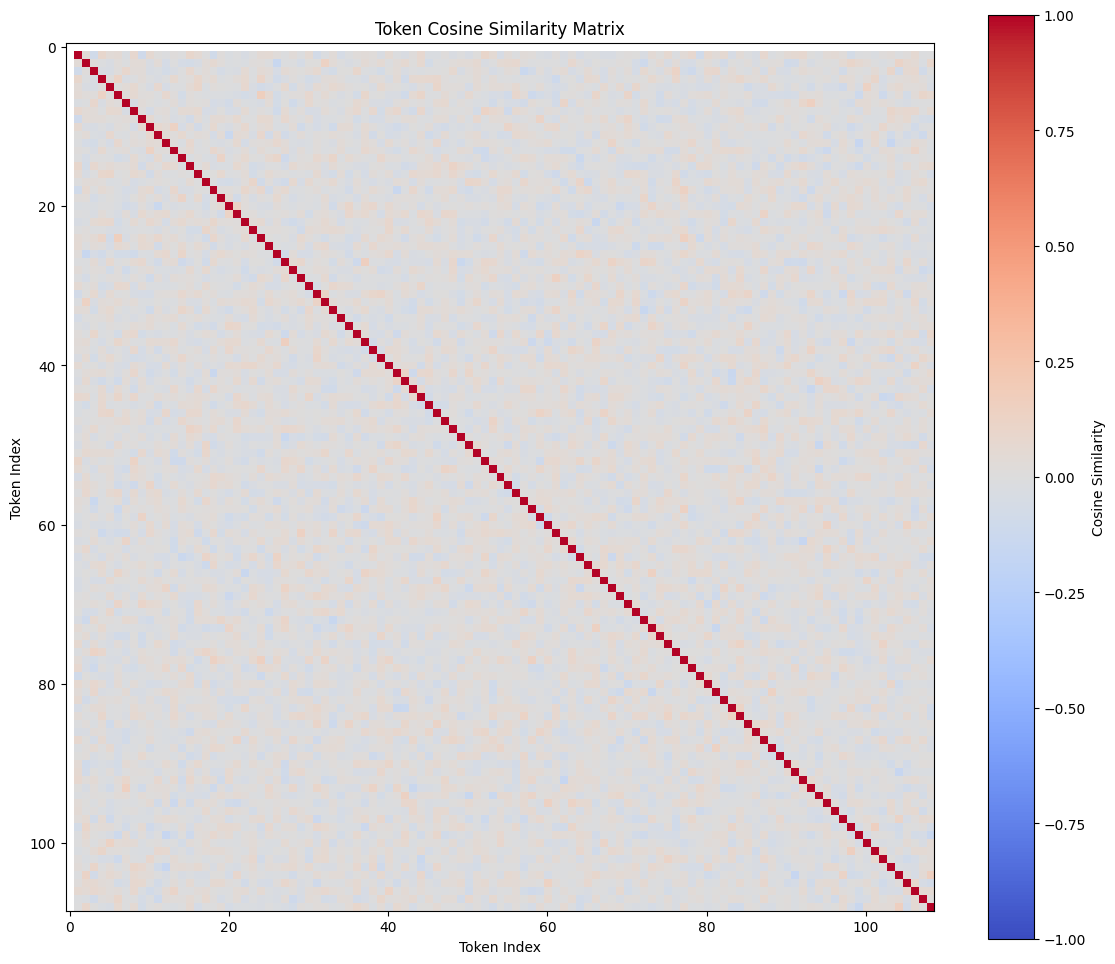

Example similar tokens (top-5 for first 10 tokens):
<PAD>        -> ['pants', 'this', 'man', 'wears', 'are']
<START>      -> ['<START>', 'upper', 'has', 'lower', 'person']
<END>        -> ['<END>', 'wears', 'suspenders', 'three-point', 'skirt']
the          -> ['the', 'leather', 'woman', 'stripe', 'graphic']
lower        -> ['lower', 'is', ',', 'her', 'plaid']
clothing     -> ['clothing', 'chiffon', 'denim', 'plaid', 'sleeveless']
is           -> ['is', ',', 'lower', 'waist', 'eyeglasses']
of           -> ['of', 'no', 'medium-sleeve', 'neck', 'the']
long         -> ['long', 'upper', 'woman', 'person', 'shirt']
length       -> ['length', 'guy', 'waist', 'woman', 'outer']


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# === 获取 embedding ===
emb = model.decoder.token_emb.weight.detach().cpu().numpy()  # [109, 512]
tokens = list(token2id.keys())

# === 归一化为单位向量 ===
emb_norm = emb / np.linalg.norm(emb, axis=1, keepdims=True)

# === 余弦相似度矩阵 ===
sim_matrix = emb_norm @ emb_norm.T   # shape [109, 109]

plt.figure(figsize=(14, 12))
plt.imshow(sim_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Cosine Similarity")
plt.title("Token Cosine Similarity Matrix")
plt.xlabel("Token Index")
plt.ylabel("Token Index")
plt.show()

# 打印一些样本，用于感性理解
print("Example similar tokens (top-5 for first 10 tokens):")
for i in range(10):
    sims = sim_matrix[i]
    top5 = sims.argsort()[::-1][1:6]
    print(f"{tokens[i]:12s} -> {[tokens[j] for j in top5]}")


方差范围: [0.608942, 1.369049]
平均方差: 0.996057


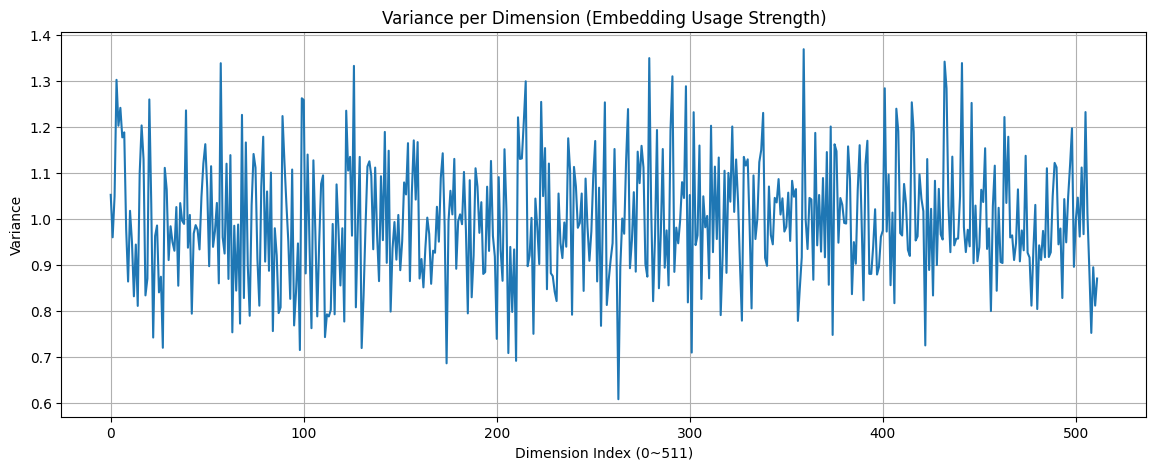

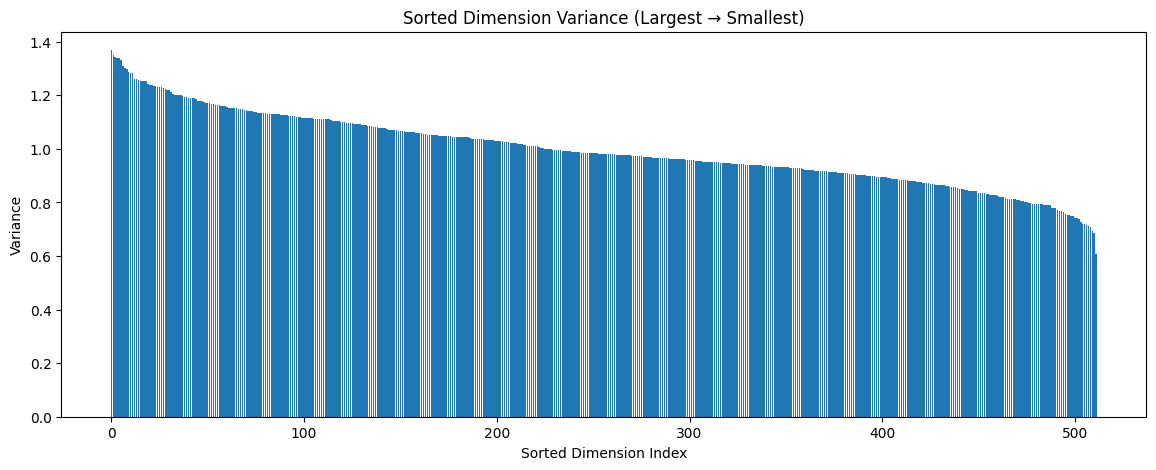

有效维度估计（方差超过最大值 5% 的维度数量）: 512 / 512


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# === 获取 embedding ===
emb = model.decoder.token_emb.weight.detach().cpu().numpy()  # [109, 512]

# === 每个维度的方差 ===
dim_var = emb.var(axis=0)   # shape [512]

print(f"方差范围: [{dim_var.min():.6f}, {dim_var.max():.6f}]")
print(f"平均方差: {dim_var.mean():.6f}")

# === 方差折线图 ===
plt.figure(figsize=(14,5))
plt.plot(dim_var)
plt.title("Variance per Dimension (Embedding Usage Strength)")
plt.xlabel("Dimension Index (0~511)")
plt.ylabel("Variance")
plt.grid(True)
plt.show()

# === 排序后的方差柱状图 ===
sorted_var = np.sort(dim_var)[::-1]

plt.figure(figsize=(14,5))
plt.bar(np.arange(len(sorted_var)), sorted_var)
plt.title("Sorted Dimension Variance (Largest → Smallest)")
plt.xlabel("Sorted Dimension Index")
plt.ylabel("Variance")
plt.show()

# === 打印有效维度估计 ===
threshold = dim_var.max() * 0.05  # 5% of max variance
effective_dims = np.sum(dim_var > threshold)

print(f"有效维度估计（方差超过最大值 5% 的维度数量）: {effective_dims} / 512")


## epoch 0-19 的 train loss & test loss & loss metrics 曲线

In [10]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

epochs = list(range(20))

train_losses = []
test_losses = []
meteors = []
rouges = []
ciders = []
spices = []

for epoch in epochs:
    # ------------ 读取 train 每个样本 loss 并求均值 ------------
    train_file = os.path.join(train_json_path, f"epoch{epoch}_train_stage1.json")
    with open(train_file, "r") as f:
        train_data = json.load(f)

    losses = [s["loss"] for s in train_data if "loss" in s]
    avg_train_loss = float(np.mean(losses)) if len(losses) > 0 else float("nan")
    train_losses.append(avg_train_loss)

    # ------------ 读取 test summary ------------
    test_file = os.path.join(test_json_path, f"epoch{epoch}_test", "final_results.json")
    with open(test_file, "r") as f:
        test_data = json.load(f)

    summary = test_data["summary"]
    test_losses.append(summary.get("avg_loss", float("nan")))
    avg_metrics = summary.get("avg_metrics", {})

    meteors.append(avg_metrics.get("METEOR", float("nan")))
    rouges.append(avg_metrics.get("ROUGE_L", float("nan")))
    ciders.append(avg_metrics.get("CIDEr", float("nan")))
    spices.append(avg_metrics.get("SPICE", float("nan")))

# ================== 图 1：train & test loss 曲线 ==================
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker="o", label="Train loss")
plt.plot(epochs, test_losses, marker="o", label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss vs Epoch")
plt.xticks(epochs)          # ★ 强制 epoch 刻度
plt.grid(True)
plt.legend()
plt.show()

# ================== 图 2：METEOR ==================
plt.figure(figsize=(8, 5))
plt.plot(epochs, meteors, marker="o")
plt.xlabel("Epoch")
plt.ylabel("METEOR")
plt.title("METEOR vs Epoch")
plt.xticks(epochs)
plt.grid(True)
plt.show()

# ================== 图 3：ROUGE-L ==================
plt.figure(figsize=(8, 5))
plt.plot(epochs, rouges, marker="o")
plt.xlabel("Epoch")
plt.ylabel("ROUGE-L")
plt.title("ROUGE-L vs Epoch")
plt.xticks(epochs)
plt.grid(True)
plt.show()

# ================== 图 4：CIDEr ==================
plt.figure(figsize=(8, 5))
plt.plot(epochs, ciders, marker="o")
plt.xlabel("Epoch")
plt.ylabel("CIDEr")
plt.title("CIDEr vs Epoch")
plt.xticks(epochs)
plt.grid(True)
plt.show()

# ================== 图 5：SPICE ==================
plt.figure(figsize=(8, 5))
plt.plot(epochs, spices, marker="o")
plt.xlabel("Epoch")
plt.ylabel("SPICE")
plt.title("SPICE vs Epoch")
plt.xticks(epochs)
plt.grid(True)
plt.show()


NameError: name 'train_json_path' is not defined

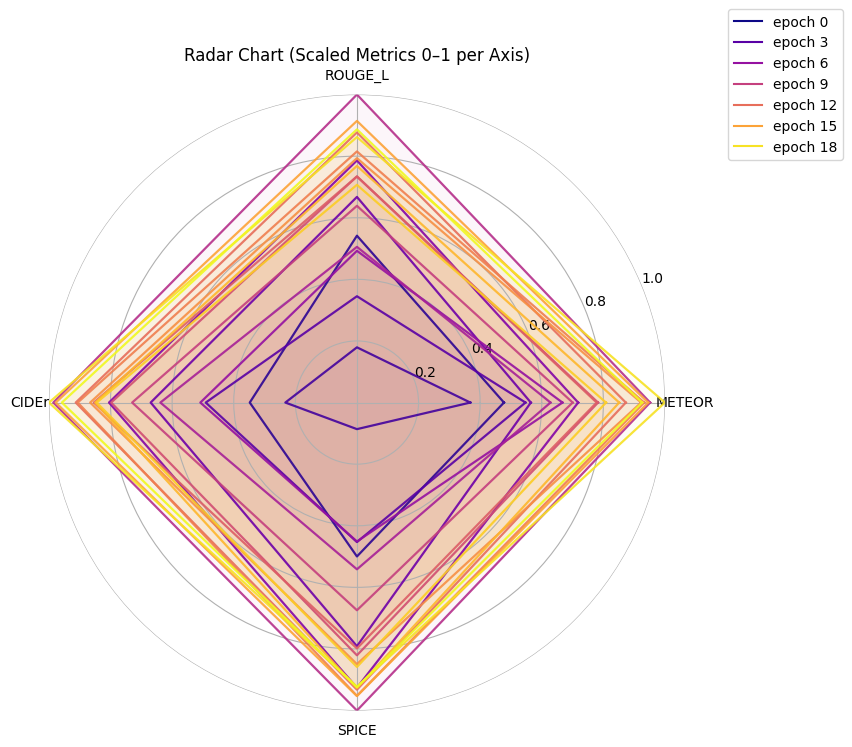

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ====== 基础数据 ======
metric_names = ["METEOR", "ROUGE_L", "CIDEr", "SPICE"]
metrics_per_epoch = np.array([
    meteors,
    rouges,
    ciders,
    spices
]).T   # shape: (20, 4)

num_epochs = metrics_per_epoch.shape[0]
num_metrics = metrics_per_epoch.shape[1]

# ====== 对每个指标独立进行 0-1 归一化 ======
scaled = np.zeros_like(metrics_per_epoch)
for j in range(num_metrics):
    col = metrics_per_epoch[:, j]
    min_v, max_v = col.min(), col.max()
    if max_v - min_v < 1e-9:
        scaled[:, j] = 0
    else:
        scaled[:, j] = (col - min_v) / (max_v - min_v)

# ====== 雷达图角度 ======
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False)
angles = np.concatenate([angles, angles[:1]])

# ====== 绘图 ======
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# 背景去掉
ax.set_facecolor("white")
ax.patch.set_alpha(0.0)
plt.gca().spines['polar'].set_visible(False)

# 使用 plasma 显色（更明显的渐变）
colors = plt.cm.plasma(np.linspace(0, 1, num_epochs))

# 画每个 epoch 曲线
for i in range(num_epochs):
    vals = scaled[i]
    vals = np.concatenate([vals, vals[:1]])
    ax.plot(angles, vals, color=colors[i], alpha=0.9, linewidth=1.6)
    ax.fill(angles, vals, color=colors[i], alpha=0.04)

# 设置轴标签
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metric_names)

# 半径 0~1
ax.set_ylim(0, 1)

plt.title("Radar Chart (Scaled Metrics 0–1 per Axis)")

# 只标几个 epoch 避免太挤
handles = []
for i in range(0, num_epochs, 3):
    h, = ax.plot([], [], color=colors[i], label=f"epoch {i}")
    handles.append(h)

ax.legend(handles=handles, loc="upper right", bbox_to_anchor=(1.3, 1.15))

plt.show()



## 对epoch8 test json中全部样本，每条样本都有loss+四个指标，相当于一个五维向量
那么 loss与四个指标
第一个指标与其余三个指标
...这样可以绘制阶梯子图布局
每个子图都是两两指标的联系

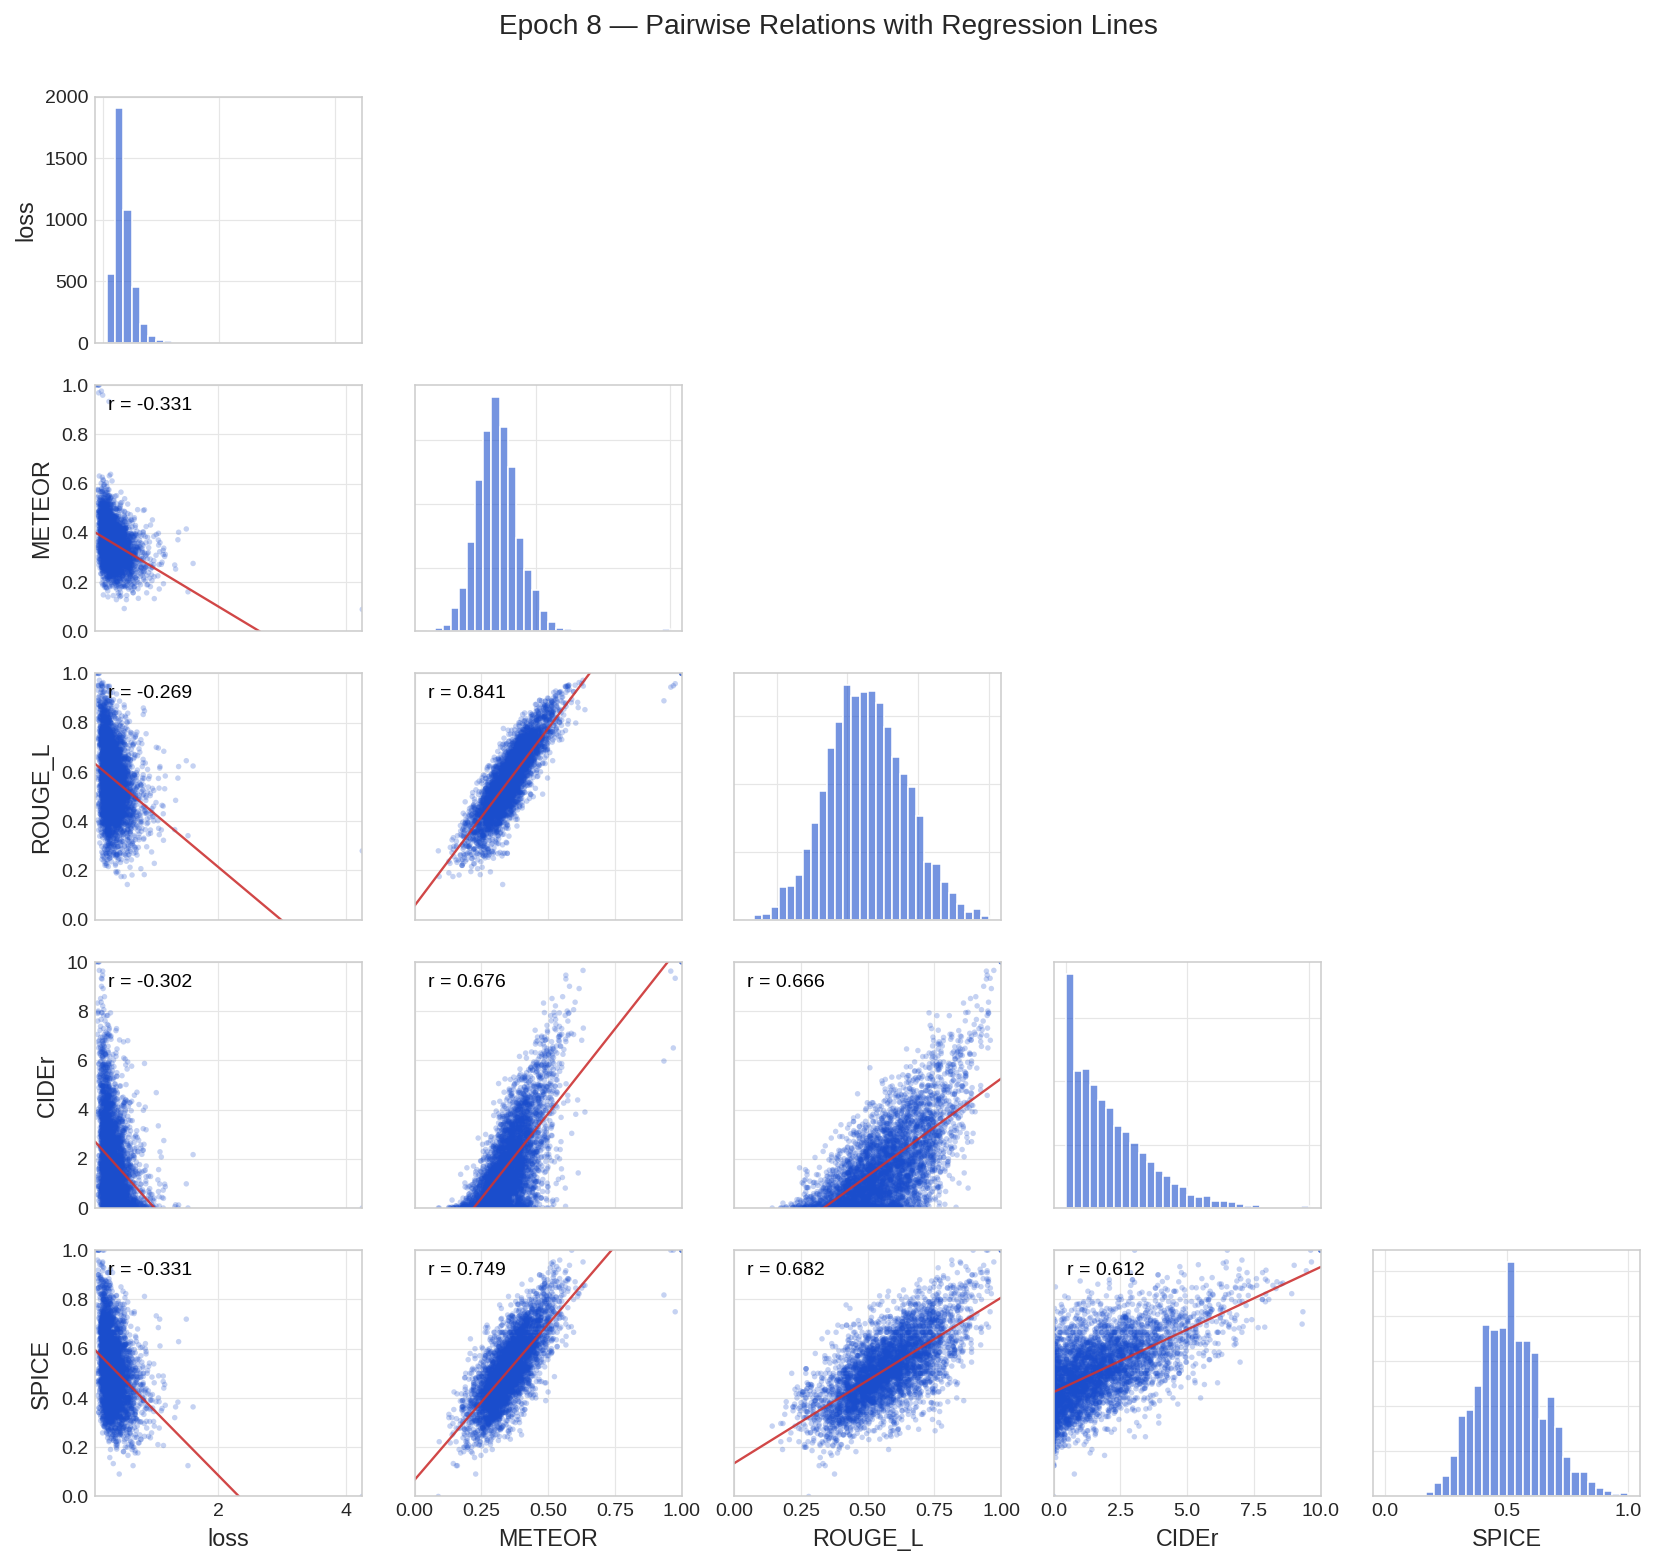

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "axes.linewidth": 0.8,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 140
})

scatter_color = (0.1, 0.3, 0.8, 0.25)
hist_color    = (0.1, 0.3, 0.8, 0.6)
line_color    = (0.8, 0.2, 0.2, 0.9)

# ====== 读 epoch 8 ======
epoch = 8
test_file = os.path.join(test_json_path, f"epoch{epoch}_test", "final_results.json")
samples = json.load(open(test_file))["samples"]

losses  = np.array([s["loss"] for s in samples])
meteors = np.array([s["metrics"]["METEOR"] for s in samples])
rouges  = np.array([s["metrics"]["ROUGE_L"] for s in samples])
ciders  = np.array([s["metrics"]["CIDEr"] for s in samples])
spices  = np.array([s["metrics"]["SPICE"] for s in samples])

names    = ["loss", "METEOR", "ROUGE_L", "CIDEr", "SPICE"]
all_data = np.vstack([losses, meteors, rouges, ciders, spices]).T
num_vars = all_data.shape[1]

def clip_range(name, vmin, vmax):
    # 针对不同指标做合理裁剪
    if name == "loss":
        return max(0.0, vmin), vmax
    if name in ["METEOR", "ROUGE_L", "SPICE"]:
        return 0.0, 1.0
    if name == "CIDEr":
        return max(0.0, vmin), vmax
    return vmin, vmax

fig, axes = plt.subplots(num_vars, num_vars, figsize=(12, 12))
fig.suptitle(f"Epoch {epoch} — Pairwise Relations with Regression Lines", y=0.93)

for i in range(num_vars):
    for j in range(num_vars):
        ax = axes[i, j]

        if i < j:
            ax.axis("off")
            continue

        x = all_data[:, j]
        y = all_data[:, i]

        if i == j:
            ax.hist(x, bins=30, color=hist_color, edgecolor="white", linewidth=0.8)
        else:
            ax.scatter(x, y, s=8, alpha=0.25, color=scatter_color, edgecolor="none")

            # 线性回归（过滤掉常量列的情况）
            if np.std(x) > 1e-8 and np.std(y) > 1e-8:
                slope, intercept, r_value, *_ = linregress(x, y)

                # 只在当前变量的有效范围内画线
                xmin, xmax = np.min(x), np.max(x)
                ymin, ymax = np.min(y), np.max(y)
                xmin, xmax = clip_range(names[j], xmin, xmax)
                ymin, ymax = clip_range(names[i], ymin, ymax)

                xs = np.linspace(xmin, xmax, 200)
                ys = intercept + slope * xs
                ax.plot(xs, ys, color=line_color, linewidth=1.2)

                # r 值显示
                ax.text(
                    0.05, 0.9,
                    f"r = {r_value:.3f}",
                    transform=ax.transAxes,
                    fontsize=10,
                    color="black"
                )

                ax.set_xlim(xmin, xmax)
                ax.set_ylim(ymin, ymax)

        # 轴标签
        if i == num_vars - 1:
            ax.set_xlabel(names[j])
        else:
            ax.set_xticklabels([])

        if j == 0:
            ax.set_ylabel(names[i])
        else:
            ax.set_yticklabels([])

        ax.grid(color="0.9", linewidth=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [1]:
import os
import json
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# =========================
# 1. Load epoch 8 metrics
# =========================
epoch = 8
test_file = os.path.join(test_json_path, f"epoch{epoch}_test", "final_results.json")
samples = json.load(open(test_file))["samples"]

meteors = np.array([s["metrics"]["METEOR"] for s in samples])
rouges  = np.array([s["metrics"]["ROUGE_L"] for s in samples])
ciders  = np.array([s["metrics"]["CIDEr"]  for s in samples])
spices  = np.array([s["metrics"]["SPICE"]  for s in samples])

metric_names = ["METEOR", "ROUGE_L", "CIDEr", "SPICE"]
X = np.vstack([meteors, rouges, ciders, spices]).T   # shape: [N, 4]

# =========================
# 2. Standardize (必需，避免量纲差异影响 PCA)
# =========================
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# =========================
# 3. PCA
# =========================
pca = PCA(n_components=4)
pca.fit(X_std)

explained = pca.explained_variance_ratio_
components = pca.components_

print("==== Explained Variance Ratio (各主成分方差解释率) ====")
for i, ev in enumerate(explained):
    print(f"PC{i+1}: {ev:.4f}")

print("\n==== PCA Component Loadings (各 PC 对应的系数) ====")
for i, comp in enumerate(components):
    print(f"PC{i+1}:", ["%+0.3f" % v for v in comp])

# =========================
# 4. PC1 reward interpretation
# =========================
pc1 = components[0]
print("\n==== PC1 coefficients (Standardized metrics) ====")
for name, coef in zip(metric_names, pc1):
    print(f"  {name:8s}: {coef:+.3f}")

# 归一化权重（绝对值和为 1，便于 interpret）
abs_sum = np.sum(np.abs(pc1))
norm_pc1 = pc1 / abs_sum

print("\n==== PC1 Normalized Contribution (绝对贡献归一化后) ====")
for name, coef in zip(metric_names, norm_pc1):
    print(f"  {name:8s}: {coef:+.3f}")

# 给一个人类可读的 reward 公式
formula_terms = [f"{coef:+.3f}·z_{name}" for name, coef in zip(metric_names, pc1)]
print("\n==== 推荐 reward (标准化后使用) ====")
print("Reward ≈", "  ".join(formula_terms))


NameError: name 'test_json_path' is not defined

In [21]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# =========================
# 1. 读取 epoch 8 test 数据
# =========================
epoch = 8
test_file = os.path.join(test_json_path, f"epoch{epoch}_test", "final_results.json")
samples = json.load(open(test_file))["samples"]

meteors = np.array([s["metrics"]["METEOR"] for s in samples])
rouges  = np.array([s["metrics"]["ROUGE_L"] for s in samples])
ciders  = np.array([s["metrics"]["CIDEr"]  for s in samples])
spices  = np.array([s["metrics"]["SPICE"]  for s in samples])

metric_names = ["METEOR", "ROUGE_L", "CIDEr", "SPICE"]
X = np.vstack([meteors, rouges, ciders, spices]).T   # shape [N,4]

# =========================
# 2. 标准化 + PCA
# =========================
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA(n_components=4)
pca.fit(X_std)

pc1 = pca.components_[0]  # shape (4,)
print("PC1 coefficients:", pc1)

# =========================
# 3. 计算每个样本的 PC1 reward
# =========================
rewards = X_std @ pc1   # shape [N]

# =========================
# 4. 按 reward 降序排序
# =========================
order = np.argsort(-rewards)
sorted_rewards = rewards[order]
sorted_samples = [samples[i] for i in order]

# =========================
# 5. 纵向绘制排序 reward 曲线
# =========================
plt.figure(figsize=(10,6))
plt.plot(sorted_rewards)
plt.title(f"PC1 Reward Sorted (Epoch {epoch})")
plt.xlabel("Sample Rank (High → Low)")
plt.ylabel("PC1 Reward")
plt.grid(alpha=0.3)
plt.show()

# =========================
# 6. 打印前 10 （reward 最大）
# =========================
print("\n========== TOP 10 SAMPLES (Highest Reward) ==========\n")
for i in range(10):
    s = sorted_samples[i]
    print(f"[Rank {i+1}]  Reward = {sorted_rewards[i]:.4f}")
    print(" GT :", s["gt_text"])
    print(" Pred:", s["pred_text"])
    print("-" * 80)

# =========================
# 7. 打印倒数 10（reward 最小）
# =========================
print("\n========== BOTTOM 10 SAMPLES (Lowest Reward) ==========\n")
for i in range(1, 11):
    s = sorted_samples[-i]
    print(f"[Rank -{i}]  Reward = {sorted_rewards[-i]:.4f}")
    print(" GT :", s["gt_text"])
    print(" Pred:", s["pred_text"])
    print("-" * 80)


NameError: name 'test_json_path' is not defined

In [34]:
import numpy as np

# 假设已经有：
# rewards         : shape [N]
# order           : argsort(-rewards)  (从大到小的索引)
# sorted_rewards  : rewards[order]
# sorted_samples  : [samples[i] for i in order]

N = len(sorted_rewards)
num_segments = 4
k_per_segment = 10

segments = np.array_split(np.arange(N), num_segments)

for seg_id, idxs in enumerate(segments):
    print(f"\n========== Segment {seg_id+1}/{num_segments} ==========")
    print(f"Reward 大致范围: [{sorted_rewards[idxs[0]]:.3f}, {sorted_rewards[idxs[-1]]:.3f}]")
    
    # 在这一段里等间隔取 k 个样本（也可以改成随机抽样）
    if len(idxs) < k_per_segment:
        chosen = idxs
    else:
        chosen = np.linspace(0, len(idxs)-1, k_per_segment, dtype=int)
        chosen = idxs[chosen]
    
    for rank_idx in chosen:
        s = sorted_samples[rank_idx]
        r = sorted_rewards[rank_idx]
        rank = rank_idx + 1  # 1-based rank
        print(f"\n[Global Rank {rank}/{N}]  Reward = {r:.4f}")
        print(" GT  :", s['gt_text'])
        print(" Pred:", s['pred_text'])



========== Segment 1/4 ==========
Reward 大致范围: [9.810, 1.035]

[Global Rank 1/4255]  Reward = 9.8103
 GT  : his shirt has short sleeves , cotton fabric and graphic patterns .
 Pred: his shirt has short sleeves , cotton fabric and graphic patterns .

[Global Rank 119/4255]  Reward = 3.8224
 GT  : the person is wearing a sleeveless tank shirt with pure color patterns and a long pants . the tank shirt is with cotton fabric . the neckline of the tank shirt is crew . the pants are with cotton fabric and pure color patterns . there is an accessory on her wrist . this woman is wearing a ring on her finger .
 Pred: this woman is wearing a sleeveless tank shirt with pure color patterns . the tank shirt is with cotton fabric and its neckline is crew . this woman wears a long trousers . the trousers are with cotton fabric and pure color patterns . there is an accessory on her wrist . this woman is wearing a ring on her finger .

[Global Rank 237/4255]  Reward = 2.9896
 GT  : the female is wearin

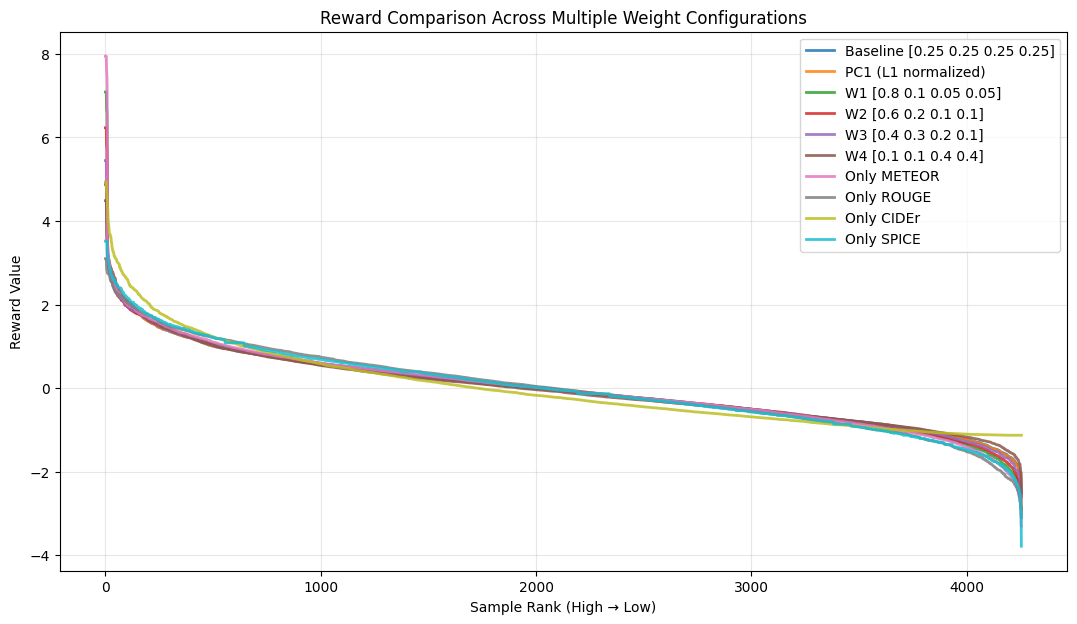



     Result Segments for Weight: Baseline [0.25 0.25 0.25 0.25]

========== Segment 1/4 (Baseline [0.25 0.25 0.25 0.25]) ==========
Reward 范围: [0.516, 4.874]

[Rank 58/4255]  Reward = 4.8740
 GT  : the upper clothing has long sleeves , cotton fabric and plaid patterns . it has a lapel neckline .
 Pred: the upper clothing has long sleeves , cotton fabric and plaid patterns . it has a lapel neckline .
--------------------------------------------------------------------------------

[Rank 3850/4255]  Reward = 1.9172
 GT  : the person is wearing a sleeveless tank shirt with pure color patterns and a long pants . the tank shirt is with cotton fabric . the neckline of the tank shirt is crew . the pants are with cotton fabric and pure color patterns . there is an accessory on her wrist . this woman is wearing a ring on her finger .
 Pred: this woman is wearing a sleeveless tank shirt with pure color patterns . the tank shirt is with cotton fabric and its neckline is crew . this woman wears 

In [32]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ---------------------------
# 加载 epoch8 test 数据
# ---------------------------
epoch = 8
test_json_path = "/home/chenzhican/zhangzilu/NNDL-course-captioning/outputs/eval_results"
test_file = os.path.join(test_json_path, f"epoch{epoch}_test", "final_results.json")
samples = json.load(open(test_file))["samples"]

# 取指标
meteors = np.array([s["metrics"]["METEOR"] for s in samples])
rouges  = np.array([s["metrics"]["ROUGE_L"] for s in samples])
ciders  = np.array([s["metrics"]["CIDEr"]  for s in samples])
spices  = np.array([s["metrics"]["SPICE"]  for s in samples])
X = np.vstack([meteors, rouges, ciders, spices]).T   # [N,4]

metric_names = ["METEOR", "ROUGE_L", "CIDEr", "SPICE"]


# ============================
# 1. z-score 标准化
# ============================
scaler = StandardScaler()
X_std = scaler.fit_transform(X)


# ============================
# 2. PCA 权重（L1=1）
# ============================
pca = PCA(n_components=4)
pca.fit(X_std)
pc1 = pca.components_[0]

if pc1.sum() < 0:
    pc1 = -pc1

pc1_L1 = pc1 / pc1.sum()


# ============================
# 3. 多组权重配置（全部自动 L1 归一）
# ============================

weight_configs = {
    "Baseline [0.25 0.25 0.25 0.25]": np.ones(4)/4,
    "PC1 (L1 normalized)": pc1_L1,

    # 你之前的
    "W1 [0.8 0.1 0.05 0.05]": np.array([0.8, 0.1, 0.05, 0.05]),
    "W2 [0.6 0.2 0.1 0.1]": np.array([0.6, 0.2, 0.1, 0.1]),
    "W3 [0.4 0.3 0.2 0.1]": np.array([0.4, 0.3, 0.2, 0.1]),
    "W4 [0.1 0.1 0.4 0.4]": np.array([0.1, 0.1, 0.4, 0.4]),

    # ============================
    # 新增：四个单独指标
    # ============================
    "Only METEOR": np.array([1.0, 0.0, 0.0, 0.0]),
    "Only ROUGE":  np.array([0.0, 1.0, 0.0, 0.0]),
    "Only CIDEr":  np.array([0.0, 0.0, 1.0, 0.0]),
    "Only SPICE":  np.array([0.0, 0.0, 0.0, 1.0]),
}


# 全部 L1 normalize
for k in weight_configs:
    weight_configs[k] = weight_configs[k] / weight_configs[k].sum()


# ============================
# 4. 计算 reward、排序、绘图
# ============================

plt.figure(figsize=(13,7))

reward_dict = {}   # 后续抽样也能用

for name, w in weight_configs.items():
    reward = X_std @ w
    reward_dict[name] = reward
    
    order = np.argsort(-reward)
    sorted_reward = reward[order]

    plt.plot(sorted_reward, label=name, linewidth=2, alpha=0.85)

plt.xlabel("Sample Rank (High → Low)")
plt.ylabel("Reward Value")
plt.title("Reward Comparison Across Multiple Weight Configurations")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# ============================
# 5. 抽样输出函数
# ============================

def print_segment(name, reward):
    print("\n\n========================================================")
    print(f"     Result Segments for Weight: {name}")
    print("========================================================")

    order = np.argsort(-reward)
    N = len(order)
    seg_size = N // 4
    
    for i in range(4):
        a = i * seg_size
        b = (i+1) * seg_size if i < 3 else N
        print(f"\n========== Segment {i+1}/4 ({name}) ==========")
        print(f"Reward 范围: [{reward[order[b-1]]:.3f}, {reward[order[a]]:.3f}]")

        idxs = np.linspace(a, b-1, 10, dtype=int)
        for idx in idxs:
            s = samples[order[idx]]
            print(f"\n[Rank {order[idx]+1}/{N}]  Reward = {reward[order[idx]]:.4f}")
            print(" GT  :", s["gt_text"])
            print(" Pred:", s["pred_text"])
            print("-"*80)


# 用法示例（打印 baseline 和 PC1）
print_segment("Baseline [0.25 0.25 0.25 0.25]", reward_dict["Baseline [0.25 0.25 0.25 0.25]"])
print_segment("PC1 (L1 normalized)", reward_dict["PC1 (L1 normalized)"])
print_segment("W1 [0.8 0.1 0.05 0.05]", reward_dict["W1 [0.8 0.1 0.05 0.05]"])


In [38]:
# ============================================
# 0. 前提：假设你已经算好了：
#    reward_avg、pc1_reward、samples、order_avg、order_pc1
# ============================================

def print_top_100(order, reward, name="Reward"):
    print(f"\n==================== TOP 100 SAMPLES ({name}) ====================")
    topk = order[:100]   # 取前100

    for rank_idx, idx in enumerate(topk, start=1):
        s = samples[idx]
        r = reward[idx]
        print(f"\n[Rank {rank_idx}/4255] Reward = {r:.4f}")
        print(" GT  :", s["gt_text"])
        print(" Pred:", s["pred_text"])
        print("-"*80)


# ============================================
# 1. 打印 PC1 Reward Top 100
# ============================================
print_top_100(order_pc1, pc1_reward, "PC1 Reward")


# ============================================
# 2. 打印 Baseline Reward Top 100
# ============================================
print_top_100(order_avg, reward_avg, "Baseline Avg Reward")



==================== TOP 100 SAMPLES (PC1 Reward) ====================

[Rank 1/4255] Reward = 9.8103
 GT  : his shirt has short sleeves , cotton fabric and graphic patterns .
 Pred: his shirt has short sleeves , cotton fabric and graphic patterns .
--------------------------------------------------------------------------------

[Rank 2/4255] Reward = 9.8103
 GT  : the upper clothing has short sleeves , cotton fabric and pure color patterns .
 Pred: the upper clothing has short sleeves , cotton fabric and pure color patterns .
--------------------------------------------------------------------------------

[Rank 3/4255] Reward = 9.8103
 GT  : the upper clothing has long sleeves , cotton fabric and plaid patterns . it has a lapel neckline .
 Pred: the upper clothing has long sleeves , cotton fabric and plaid patterns . it has a lapel neckline .
--------------------------------------------------------------------------------

[Rank 4/4255] Reward = 9.8103
 GT  : the upper clothing has

## 注意力图可视化

## 残差流分析

## 单独语言块

扫描目录: /home/chenzhican/zhangzilu/NNDL-course-captioning/trains/outputs_lm
发现的实验配置：
blocks_1: emb=512, blocks=1, size_index=512, len(train)=20, len(test)=20
blocks_2: emb=512, blocks=2, size_index=1024, len(train)=20, len(test)=20
blocks_3: emb=512, blocks=3, size_index=1536, len(train)=20, len(test)=20
blocks_4: emb=512, blocks=4, size_index=2048, len(train)=20, len(test)=20
blocks_5: emb=512, blocks=5, size_index=2560, len(train)=20, len(test)=20
emb1024_block4_learn: emb=1024, blocks=1, size_index=1024, len(train)=20, len(test)=20
emb109_block1: emb=109, blocks=1, size_index=109, len(train)=20, len(test)=20
emb109_block2: emb=109, blocks=2, size_index=218, len(train)=20, len(test)=20
emb109_block3: emb=109, blocks=3, size_index=327, len(train)=20, len(test)=20
emb109_block4: emb=109, blocks=4, size_index=436, len(train)=20, len(test)=20
emb16_block8_frozen: emb=16, blocks=1, size_index=16, len(train)=20, len(test)=20
emb16_block8_learn: emb=16, blocks=1, size_index=16, len(train)=20,

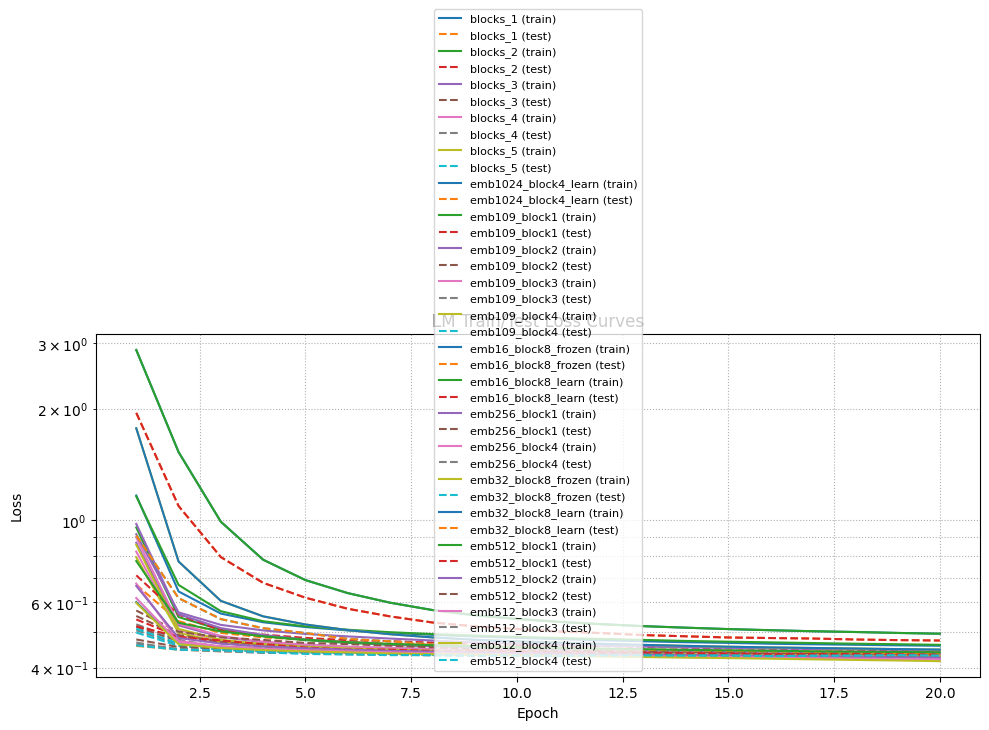

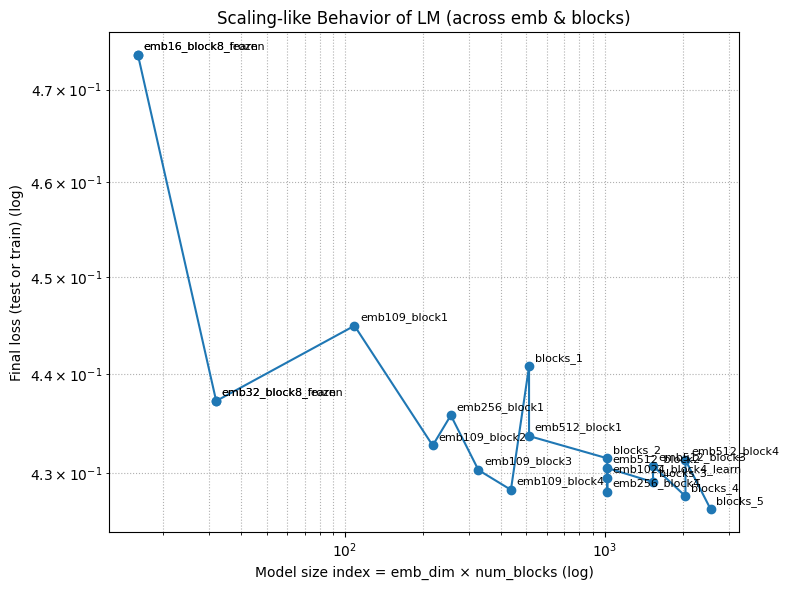

In [2]:
import os
import json
import math
from typing import List, Dict, Tuple

import matplotlib.pyplot as plt

# ================== 1. 路径设置 ==================
# 如果你前面已经定义过 path1，就注释掉下一行
path1 = "/home/chenzhican/zhangzilu/NNDL-course-captioning/trains/outputs_lm"
OUT_DIR = path1

print("扫描目录:", OUT_DIR)


# ================== 2. 一些工具函数 ==================
def parse_exp_name(name: str) -> Tuple[int, int]:
    """
    根据目录名推断 (embedding_dim, num_blocks)

    约定：
        - "blocks_1"      -> (512, 1)
        - "blocks_2"      -> (512, 2)
        - "emb109_block3" -> (109, 3)
        - "emb256_block4" -> (256, 4)
        - "emb512_block2" -> (512, 2)
    """
    emb_dim = 512
    num_blocks = 1

    if name.startswith("blocks_"):
        try:
            num_blocks = int(name.split("_")[1])
        except Exception:
            pass
        emb_dim = 512
    elif name.startswith("emb"):
        # 形如 emb109_block3
        try:
            tmp = name.replace("emb", "")
            emb_str, blk_str = tmp.split("_block")
            emb_dim = int(emb_str)
            num_blocks = int(blk_str)
        except Exception:
            pass

    return emb_dim, num_blocks


def load_loss_json(path: str) -> Tuple[List[float], List[float]]:
    """
    尽量兼容几种 loss.json 格式：
    1) {"train": [...], "test": [...]} 或 {"train_loss": [...], "val_loss": [...]}
    2) [{"epoch": 0, "train":..., "test":...}, ...]
    """
    with open(path, "r") as f:
        data = json.load(f)

    train_losses: List[float] = []
    test_losses: List[float] = []

    # 格式 1：dict
    if isinstance(data, dict):
        train_key_candidates = ["train", "train_loss", "loss_train"]
        test_key_candidates  = ["test", "val", "val_loss", "loss_val"]

        train = None
        test = None

        for k in train_key_candidates:
            if k in data:
                train = data[k]
                break
        for k in test_key_candidates:
            if k in data:
                test = data[k]
                break

        if isinstance(train, list):
            train_losses = [float(x) for x in train]
        if isinstance(test, list):
            test_losses = [float(x) for x in test]

    # 格式 2：list of dict
    elif isinstance(data, list) and len(data) > 0 and isinstance(data[0], dict):
        for item in data:
            if "train" in item:
                train_losses.append(float(item["train"]))
            elif "train_loss" in item:
                train_losses.append(float(item["train_loss"]))

            if "test" in item:
                test_losses.append(float(item["test"]))
            elif "val" in item:
                test_losses.append(float(item["val"]))
            elif "val_loss" in item:
                test_losses.append(float(item["val_loss"]))

    return train_losses, test_losses


def collect_all_experiments(root: str) -> Dict[str, dict]:
    """
    遍历 outputs_lm 下所有子目录，收集带 loss.json 的实验。
    返回：
        {
          exp_name: {
              "emb": int,
              "blocks": int,
              "size_index": emb * blocks,
              "train_losses": [...],
              "test_losses": [...]
          }
        }
    """
    exps: Dict[str, dict] = {}

    for name in sorted(os.listdir(root)):
        exp_dir = os.path.join(root, name)
        if not os.path.isdir(exp_dir):
            continue

        loss_path = os.path.join(exp_dir, "loss.json")
        if not os.path.exists(loss_path):
            alt_loss = os.path.join(exp_dir, "logs", "loss.json")
            if os.path.exists(alt_loss):
                loss_path = alt_loss
            else:
                continue

        train_losses, test_losses = load_loss_json(loss_path)
        if not train_losses and not test_losses:
            continue

        emb, blocks = parse_exp_name(name)
        size_index = emb * blocks

        exps[name] = {
            "emb": emb,
            "blocks": blocks,
            "size_index": size_index,
            "train_losses": train_losses,
            "test_losses": test_losses,
        }

    return exps


# ================== 3. 画图函数 ==================
def plot_loss_curves(exps: Dict[str, dict]):
    """
    图 1：各实验随 epoch 的 train / test loss 曲线（y 轴 log）。
    """
    if not exps:
        print("没有找到任何实验的 loss.json")
        return

    plt.figure(figsize=(10, 6))

    for name, info in exps.items():
        train_losses = info["train_losses"]
        if train_losses:
            epochs = list(range(1, len(train_losses) + 1))
            plt.plot(epochs, train_losses, label=f"{name} (train)", linestyle="-")

        test_losses = info["test_losses"]
        if test_losses:
            ep_t = list(range(1, len(test_losses) + 1))
            plt.plot(ep_t, test_losses, label=f"{name} (test)", linestyle="--")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale("log")   # scaling-law 感觉更明显
    plt.title("LM Train/Test Loss Curves")
    plt.legend(fontsize=8)
    plt.grid(True, which="both", linestyle=":")
    plt.tight_layout()
    plt.show()


def plot_scaling_law(exps: Dict[str, dict]):
    """
    图 2：scaling law 风格图：
        x = 模型规模 size_index = emb_dim * num_blocks (log)
        y = 最终 test loss (无 test 则用 train) (log)
    """
    xs, ys, labels = [], [], []

    for name, info in exps.items():
        size_index = info["size_index"]
        test_losses = info["test_losses"]
        train_losses = info["train_losses"]

        if test_losses:
            final_loss = float(test_losses[-1])
        elif train_losses:
            final_loss = float(train_losses[-1])
        else:
            continue

        xs.append(size_index)
        ys.append(final_loss)
        labels.append(name)

    if not xs:
        print("没有可用于 scaling law 图的数据")
        return

    # 按 model size 排个序
    order = sorted(range(len(xs)), key=lambda i: xs[i])
    xs = [xs[i] for i in order]
    ys = [ys[i] for i in order]
    labels = [labels[i] for i in order]

    plt.figure(figsize=(8, 6))
    plt.plot(xs, ys, marker="o")

    # 标注一下每个点对应的实验名
    for x, y, lab in zip(xs, ys, labels):
        plt.annotate(lab, (x, y), textcoords="offset points",
                     xytext=(4, 4), fontsize=8)

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Model size index = emb_dim × num_blocks (log)")
    plt.ylabel("Final loss (test or train) (log)")
    plt.title("Scaling-like Behavior of LM (across emb & blocks)")
    plt.grid(True, which="both", linestyle=":")
    plt.tight_layout()
    plt.show()


# ================== 4. 运行 ==================
exps = collect_all_experiments(OUT_DIR)

print("发现的实验配置：")
for name, info in exps.items():
    print(
        f"{name}: emb={info['emb']}, blocks={info['blocks']}, "
        f"size_index={info['size_index']}, "
        f"len(train)={len(info['train_losses'])}, len(test)={len(info['test_losses'])}"
    )

plot_loss_curves(exps)
plot_scaling_law(exps)


发现的实验：
blocks_1: emb=109, blocks=1, len(train)=20, len(test)=20
blocks_2: emb=109, blocks=2, len(train)=20, len(test)=20
blocks_3: emb=109, blocks=3, len(train)=20, len(test)=20
blocks_4: emb=109, blocks=4, len(train)=20, len(test)=20
blocks_5: emb=109, blocks=5, len(train)=20, len(test)=20
emb1024_block4_learn: emb=1024, blocks=4, len(train)=20, len(test)=20
emb109_block1: emb=109, blocks=1, len(train)=20, len(test)=20
emb109_block2: emb=109, blocks=2, len(train)=20, len(test)=20
emb109_block3: emb=109, blocks=3, len(train)=20, len(test)=20
emb109_block4: emb=109, blocks=4, len(train)=20, len(test)=20
emb16_block8_frozen: emb=16, blocks=8, len(train)=20, len(test)=20
emb16_block8_learn: emb=16, blocks=8, len(train)=20, len(test)=20
emb256_block1: emb=256, blocks=1, len(train)=20, len(test)=20
emb256_block4: emb=256, blocks=4, len(train)=20, len(test)=20
emb32_block8_frozen: emb=32, blocks=8, len(train)=20, len(test)=20
emb32_block8_learn: emb=32, blocks=8, len(train)=20, len(test)=20


/tmp/ipykernel_3665932/3849005841.py:157: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_embs))


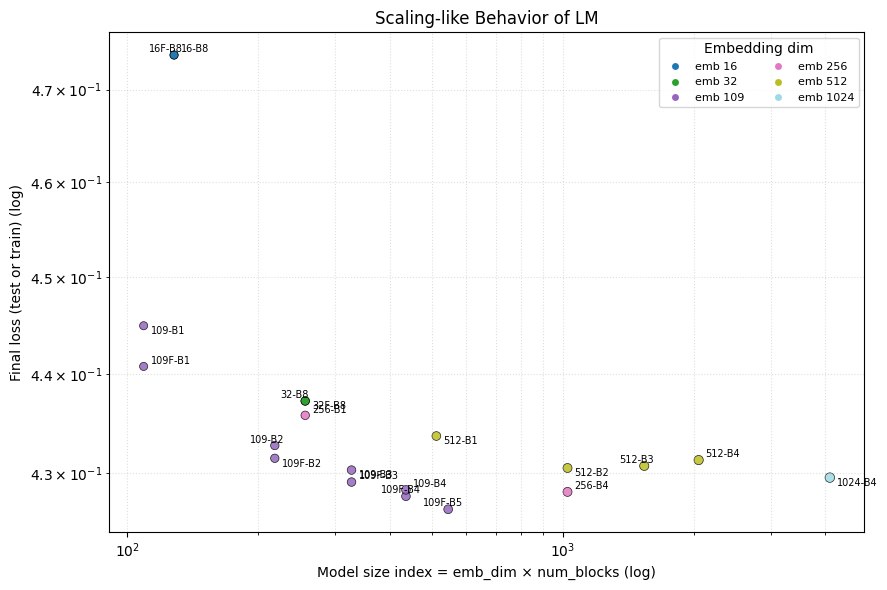

In [12]:
import os, json
import numpy as np
import matplotlib.pyplot as plt

OUT_DIR = "/home/chenzhican/zhangzilu/NNDL-course-captioning/trains/outputs_lm"

# ---------- 1. 重新定义解析函数 ----------
def parse_exp_name(name: str):
    """
    根据目录名推断 (emb_dim, num_blocks)

    约定：
      - blocks_1   -> (109, 1)  # 你说的是109维固定
      - emb109_block3          -> (109, 3)
      - emb256_block4          -> (256, 4)
      - emb16_block8_frozen    -> (16, 8)
      - emb1024_block4_learn   -> (1024, 4)
    """
    if name.startswith("blocks_"):
        blocks = int(name.split("_")[1])
        emb_dim = 109
        return emb_dim, blocks

    if name.startswith("emb"):
        # 去掉前缀 emb
        tmp = name.replace("emb", "", 1)
        # tmp 形如: "16_block8_frozen" / "109_block3" / "1024_block4_learn"
        parts = tmp.split("_block")
        emb_dim = int(parts[0])

        blocks = 1
        if len(parts) > 1 and parts[1]:
            # parts[1] 形如 "8_frozen" / "4_learn" / "3"
            tail = parts[1]
            blk_str = tail.split("_")[0]
            blocks = int(blk_str)
        return emb_dim, blocks

    # 兜底
    return 512, 1


def load_loss_json(path):
    with open(path, "r") as f:
        data = json.load(f)

    train_losses, test_losses = [], []

    if isinstance(data, dict):
        tk = ["train", "train_loss", "loss_train"]
        vk = ["test", "val", "val_loss", "loss_val"]
        train = next((data[k] for k in tk if k in data), None)
        test  = next((data[k] for k in vk if k in data), None)
        if isinstance(train, list):
            train_losses = [float(x) for x in train]
        if isinstance(test, list):
            test_losses = [float(x) for x in test]

    elif isinstance(data, list) and data and isinstance(data[0], dict):
        for item in data:
            if "train" in item:
                train_losses.append(float(item["train"]))
            elif "train_loss" in item:
                train_losses.append(float(item["train_loss"]))

            if "test" in item:
                test_losses.append(float(item["test"]))
            elif "val" in item:
                test_losses.append(float(item["val"]))
            elif "val_loss" in item:
                test_losses.append(float(item["val_loss"]))

    return train_losses, test_losses


def collect_all_experiments(root):
    exps = {}
    for name in sorted(os.listdir(root)):
        exp_dir = os.path.join(root, name)
        if not os.path.isdir(exp_dir):
            continue

        loss_path = os.path.join(exp_dir, "loss.json")
        if not os.path.exists(loss_path):
            alt = os.path.join(exp_dir, "logs", "loss.json")
            if os.path.exists(alt):
                loss_path = alt
            else:
                continue

        train_losses, test_losses = load_loss_json(loss_path)
        if not train_losses and not test_losses:
            continue

        emb, blocks = parse_exp_name(name)
        size_index = emb * blocks

        exps[name] = {
            "emb": emb,
            "blocks": blocks,
            "size_index": size_index,
            "train_losses": train_losses,
            "test_losses": test_losses,
        }
    return exps


# 重新收集 exps
exps = collect_all_experiments(OUT_DIR)
print("发现的实验：")
for n, info in exps.items():
    print(f"{n}: emb={info['emb']}, blocks={info['blocks']}, "
          f"len(train)={len(info['train_losses'])}, len(test)={len(info['test_losses'])}")


# ---------- 2. 简洁版绘图（全是圆点，短标签） ----------
def short_label(name: str, emb: int, blocks: int) -> str:
    # blocks_k -> 109F-Bk
    if name.startswith("blocks_"):
        return f"109F-B{blocks}"
    # frozen in name
    if "frozen" in name:
        return f"{emb}F-B{blocks}"
    # 其他：emb-Bk
    return f"{emb}-B{blocks}"


def plot_scaling_law_clean(exps):
    points = []

    for name, info in exps.items():
        size_index = info["size_index"]
        test_losses = info["test_losses"]
        train_losses = info["train_losses"]
        if test_losses:
            final_loss = float(test_losses[-1])
        elif train_losses:
            final_loss = float(train_losses[-1])
        else:
            continue

        emb = info["emb"]
        blocks = info["blocks"]
        label = short_label(name, emb, blocks)
        points.append((size_index, final_loss, emb, label))

    # 按 size 排序
    points.sort(key=lambda x: x[0])

    xs   = np.array([p[0] for p in points])
    ys   = np.array([p[1] for p in points])
    embs = np.array([p[2] for p in points])
    labs = [p[3] for p in points]

    # 颜色：按 emb 自动分配
    unique_embs = sorted(set(embs.tolist()))
    cmap = plt.cm.get_cmap("tab20", len(unique_embs))
    emb_to_color = {e: cmap(i) for i, e in enumerate(unique_embs)}
    cols = [emb_to_color[e] for e in embs]

    # 小圆点
    sizes = 18 + 8 * np.log10(xs)

    plt.figure(figsize=(9, 6))
    plt.scatter(xs, ys, s=sizes, c=cols, marker="o",
                alpha=0.85, edgecolors="black", linewidths=0.5)

    # 短标签 + 小字号
    offsets = [(5, 2), (5, -6), (-18, 2)]
    for i, (x, y, lab) in enumerate(zip(xs, ys, labs)):
        dx, dy = offsets[i % len(offsets)]
        plt.annotate(lab, (x, y),
                     textcoords="offset points",
                     xytext=(dx, dy),
                     fontsize=7)

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Model size index = emb_dim × num_blocks (log)", fontsize=10)
    plt.ylabel("Final loss (test or train) (log)", fontsize=10)
    plt.title("Scaling-like Behavior of LM", fontsize=12)

    # Legend: 颜色 = emb_dim
    handles = [
        plt.Line2D([0], [0], marker="o", color="w",
                   label=f"emb {e}",
                   markerfacecolor=emb_to_color[e],
                   markersize=6)
        for e in unique_embs
    ]
    plt.legend(handles=handles, fontsize=8, title="Embedding dim", ncol=2)

    plt.grid(True, which="both", linestyle=":", alpha=0.4)
    plt.tight_layout()
    plt.show()


plot_scaling_law_clean(exps)


## 注意力得分

In [15]:
import importlib
import models.vit_visual as vv

importlib.reload(vv)
from models.vit_visual import run_attn
import inspect
print(inspect.getsource(run_attn))



@torch.no_grad()
def run_attn(
    model,
    image_path: str,
    transform,
    device: str = "cuda",
) -> Tuple[Image.Image, Dict[int, torch.Tensor], Dict[int, torch.Tensor]]:

    model.eval()
    model.to(device)

    # === 1. 读图 ===
    pil = Image.open(image_path).convert("RGB")
    x = transform(pil).unsqueeze(0).to(device)

    # === 2. 触发模型 forward ===
    _ = model.greedy_decode(x)

    # === 3. 读取注意力 ===
    self_attn = {}
    cross_attn = {}

    for idx, layer in enumerate(model.decoder.decoder_layers):
        self_attn[idx] = (
            layer.self_attn_map.detach().cpu()
            if layer.self_attn_map is not None else None
        )
        cross_attn[idx] = (
            layer.cross_attn_map.detach().cpu()
            if layer.cross_attn_map is not None else None
        )

    return pil, self_attn, cross_attn



[INFO] Loading local ViT weights from: /home/chenzhican/zhangzilu/hwnndl/model/weights/jx_vit_base_p16_224-80ecf9dd.pth
[INFO] Missing keys: []
[INFO] Unexpected keys: ['head.bias', 'head.weight']
[INFO] Missing keys: []
[INFO] Unexpected keys: ['head.bias', 'head.weight']
[INFO] 权重加载成功: /home/chenzhican/zhangzilu/hwnndl/outputs/ckpts/epoch8.pth
[INFO] 权重加载成功: /home/chenzhican/zhangzilu/hwnndl/outputs/ckpts/epoch8.pth
[INFO] 共找到 44096 张 jpg 图片
[INFO] 使用的 9 张图片：
  - /data/zilu/images/WOMEN-Jackets_Coats-id_00000475-02_7_additional.jpg
  - /data/zilu/images/MEN-Shorts-id_00002380-01_7_additional.jpg
  - /data/zilu/images/WOMEN-Tees_Tanks-id_00001253-01_3_back.jpg
  - /data/zilu/images/WOMEN-Pants-id_00003919-01_7_additional.jpg
  - /data/zilu/images/WOMEN-Tees_Tanks-id_00005856-04_1_front.jpg
  - /data/zilu/images/WOMEN-Dresses-id_00003701-03_1_front.jpg
  - /data/zilu/images/WOMEN-Dresses-id_00007947-05_7_additional.jpg
  - /data/zilu/images/MEN-Pants-id_00006535-05_1_front.jpg
  - /dat

/home/chenzhican/miniconda3/envs/nndl/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


[INFO] 处理第 2 张图 (平均 5 次 forward): /data/zilu/images/MEN-Shorts-id_00002380-01_7_additional.jpg


/home/chenzhican/miniconda3/envs/nndl/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


[INFO] 处理第 3 张图 (平均 5 次 forward): /data/zilu/images/WOMEN-Tees_Tanks-id_00001253-01_3_back.jpg


/home/chenzhican/miniconda3/envs/nndl/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


[INFO] 处理第 4 张图 (平均 5 次 forward): /data/zilu/images/WOMEN-Pants-id_00003919-01_7_additional.jpg


/home/chenzhican/miniconda3/envs/nndl/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


[INFO] 处理第 5 张图 (平均 5 次 forward): /data/zilu/images/WOMEN-Tees_Tanks-id_00005856-04_1_front.jpg


/home/chenzhican/miniconda3/envs/nndl/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


[INFO] 处理第 6 张图 (平均 5 次 forward): /data/zilu/images/WOMEN-Dresses-id_00003701-03_1_front.jpg


/home/chenzhican/miniconda3/envs/nndl/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


[INFO] 处理第 7 张图 (平均 5 次 forward): /data/zilu/images/WOMEN-Dresses-id_00007947-05_7_additional.jpg


/home/chenzhican/miniconda3/envs/nndl/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


[INFO] 处理第 8 张图 (平均 5 次 forward): /data/zilu/images/MEN-Pants-id_00006535-05_1_front.jpg


/home/chenzhican/miniconda3/envs/nndl/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


[INFO] 处理第 9 张图 (平均 5 次 forward): /data/zilu/images/WOMEN-Blouses_Shirts-id_00001741-01_7_additional.jpg


/home/chenzhican/miniconda3/envs/nndl/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


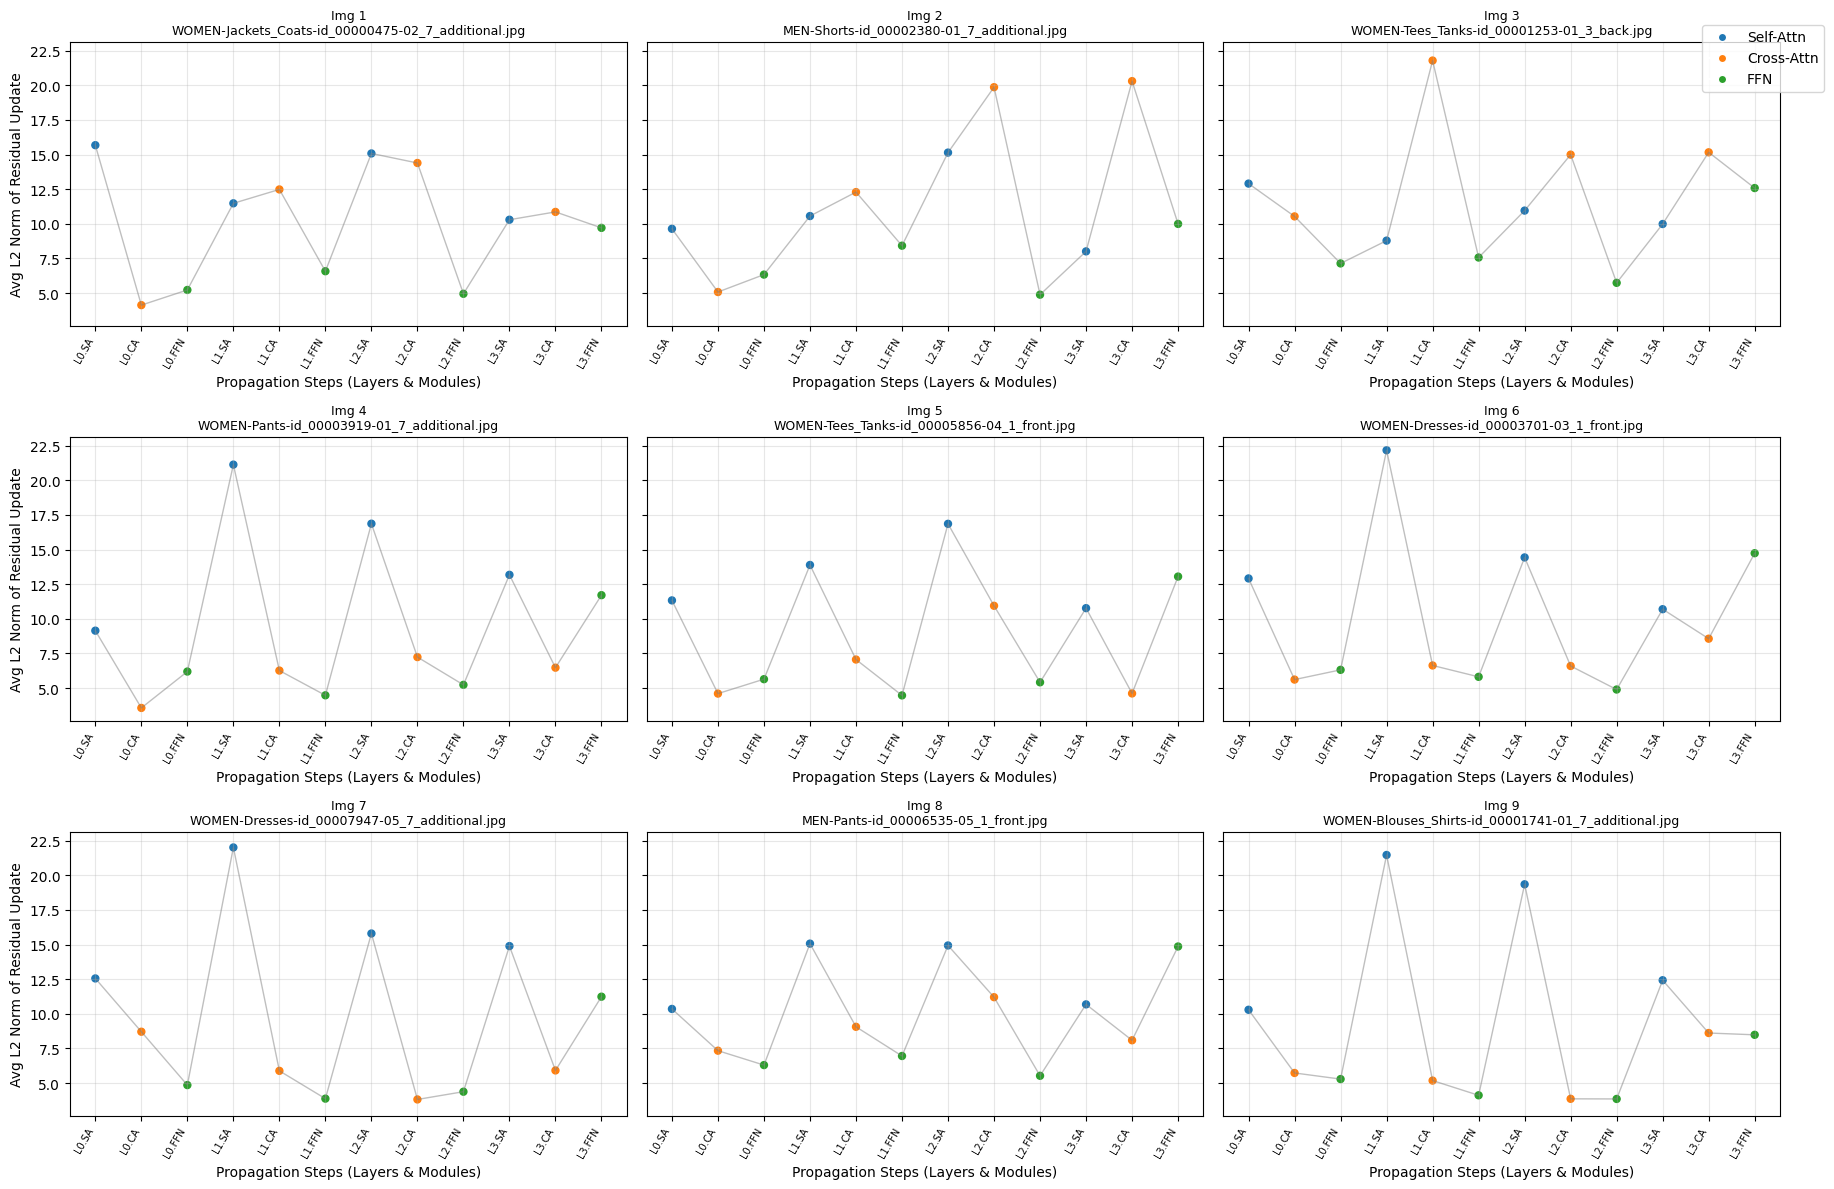

In [20]:
# ============================================
# 1. imports
# ============================================
import os
import glob
import random

import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import importlib

import sys
sys.path.append("/home/chenzhican/zhangzilu/NNDL-course-captioning")

from PIL import Image

# 强制重新加载模块，确保修改生效
import models.vit_encoder_decoder
import models.vit_visual
importlib.reload(models.vit_encoder_decoder)
importlib.reload(models.vit_visual)

from models.vit_encoder_decoder import ImageCaptionModel
from models.vit_visual import run_attn


# ============================================
# 2. transform
# ============================================
def get_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

transform = get_transform()


# ============================================
# 3. 构建模型 & 加载权重
# ============================================
model = ImageCaptionModel(
    vocab_size=109,
    pad_idx=0,
    start_idx=1,
    end_idx=2,
    d_model=512,
    n_heads=8,
    num_layers=4,
    max_len=128,
    num_img_tokens=None,
    freeze_encoder=False,
)

ckpt_path = "/home/chenzhican/zhangzilu/hwnndl/outputs/ckpts/epoch8.pth"
state = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(state, strict=True)
print(f"[INFO] 权重加载成功: {ckpt_path}")

model = model.cuda()
model.eval()


# ============================================
# 4. 随机抽取 9 张图片
# ============================================
img_root = "/data/zilu/images"  # 按需修改为你的图像根目录

# 递归匹配所有 jpg
all_imgs = glob.glob(os.path.join(img_root, "**", "*.jpg"), recursive=True)
print(f"[INFO] 共找到 {len(all_imgs)} 张 jpg 图片")

assert len(all_imgs) >= 9, "图片数量不足 9 张，请检查数据路径 img_root"

random.seed(3)
image_paths = random.sample(all_imgs, 9)

print("[INFO] 使用的 9 张图片：")
for p in image_paths:
    print("  -", p)


# ============================================
# 5. 针对单张图：多次 forward，平均“传播路径”上的写入范数
#    路径: L0.SA -> L0.CA -> L0.FFN -> L1.SA -> ...
#    针对同一个 token（这里取最后一个 token）
# ============================================
NUM_RUNS = 5  # 多次 forward 的次数，可按需调整

@torch.no_grad()
def compute_path_norms_for_image_multi(model, image_path, transform,
                                       device="cuda", num_runs=NUM_RUNS):
    """
    对同一张图做 num_runs 次完整生成，返回：
        step_labels: ["L0.SA", "L0.CA", "L0.FFN", "L1.SA", ...]
        mean_values: 每个 step 在多次 forward 上的平均 L2 范数
        step_types : ["sa", "ca", "ffn", "sa", ...]  # 用于上色
    """
    step_labels = None
    step_types = None
    all_values = []

    for r in range(num_runs):
        pil_img, self_attn, cross_attn, norms = run_attn(
            model,
            image_path=image_path,
            transform=transform,
            device=device,
        )

        layers = sorted(norms.keys())  # 一般是 [0, 1, 2, 3, ...]
        # 取最后一个 token（通常是 <END> 或句尾）
        T = norms[layers[0]]['sa'].shape[1]
        target_idx = T - 1

        cur_labels = []
        cur_values = []
        cur_types = []

        for l in layers:
            for sub in ["sa", "ca", "ffn"]:
                val = norms[l][sub][0, target_idx].item()
                cur_labels.append(f"L{l}.{sub.upper()}")
                cur_values.append(val)
                cur_types.append(sub)

        if step_labels is None:
            step_labels = cur_labels
            step_types = cur_types
        else:
            # 正常情况下长度应当一致，这里做个保护
            assert len(cur_labels) == len(step_labels), "step 数不一致，检查 run_attn/norms 逻辑"

        all_values.append(cur_values)

    all_values = np.array(all_values)  # (num_runs, num_steps)
    mean_values = all_values.mean(axis=0)
    # 如果后面想画方差，可以把 std 也返回
    # std_values = all_values.std(axis=0)

    return step_labels, mean_values, step_types


# 为三类模块准备颜色
color_map = {
    "sa": "tab:blue",   # Self-Attn
    "ca": "tab:orange", # Cross-Attn
    "ffn": "tab:green", # FFN
}


# ============================================
# 6. 画 3×3 子图
#    每个子图对应一张图片：
#    横轴: 残差流传播路径上的 step (L0.SA -> L0.CA -> L0.FFN -> ...)
#    纵轴: 多次 forward 平均后的 L2 范数
#    点颜色: 区分 SA / CA / FFN
# ============================================
from matplotlib.lines import Line2D

num_imgs = 9
rows, cols = 3, 3

fig, axes = plt.subplots(rows, cols, figsize=(18, 12), sharey=True)
axes = axes.reshape(rows, cols)

for idx, img_path in enumerate(image_paths[:num_imgs]):
    r = idx // cols
    c = idx % cols
    ax = axes[r, c]

    print(f"[INFO] 处理第 {idx+1} 张图 (平均 {NUM_RUNS} 次 forward): {img_path}")
    step_labels, mean_values, step_types = compute_path_norms_for_image_multi(
        model, img_path, transform, device="cuda", num_runs=NUM_RUNS
    )

    x = np.arange(len(mean_values))
    colors = [color_map[t] for t in step_types]

    # 灰色线表示“传播路径”上的连续写入
    ax.plot(x, mean_values, linestyle='-', linewidth=1, alpha=0.5, color='gray')
    # 彩色散点表示每个写入，并用颜色区分模块类型
    ax.scatter(x, mean_values, c=colors, s=25)

    short_name = os.path.basename(img_path)
    ax.set_title(f"Img {idx+1}\n{short_name}", fontsize=9)

    ax.set_xlabel("Propagation Steps (Layers & Modules)")
    if c == 0:
        ax.set_ylabel("Avg L2 Norm of Residual Update")

    ax.grid(True, alpha=0.3)
    ax.set_xticks(x)
    ax.set_xticklabels(step_labels, rotation=60, ha="right", fontsize=7)

# 如果将来改成 <9 张图，去掉多余子图
for idx in range(num_imgs, rows * cols):
    r = idx // cols
    c = idx % cols
    axes[r, c].axis("off")

# 全局 legend：三种模块类型
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Self-Attn',
           markerfacecolor=color_map["sa"], markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Cross-Attn',
           markerfacecolor=color_map["ca"], markersize=6),
    Line2D([0], [0], marker='o', color='w', label='FFN',
           markerfacecolor=color_map["ffn"], markersize=6),
]
fig.legend(legend_elements, ['Self-Attn', 'Cross-Attn', 'FFN'],
           loc="upper right", bbox_to_anchor=(1.02, 0.98))

plt.tight_layout()
plt.show()


## 根据上面的推理结果，